# Models II: Univariate Regression with `statsmodels`

## Learning Goals

In the previous notebook we calculated a GLM by-hand by implementing the OLS solution using `numpy`.  
In this notebook we're going to meet [`statsmodels`](https://www.statsmodels.org/stable/index.html) a new Python library that allows us to much more easily *estimate*, *evaluate*, and *compare* models to each other.

We won't be covering the full functionality of `statsmodels` as it's vast and beyond the scope of this course.  
Instead we'll be focusing on estimating regression models using [OLS in statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS-parameters) which behaves very similarily to `lm()`in R.

- Estimating a univariate regression using OLS with `statsmodels`
- Evaluating and inspecting model assumptions and predictions
- Testing simple hypotheses using model comparison
- Interpeting estimated model parameters
- Understanding parameter inference

## Slides for reference

[Modeling Data I (slides)](https://stat-intuitions.com/lectures/wk5/1.html)  
[Modeling Data II (slides)](https://stat-intuitions.com/lectures/wk5/2.html)  
[Modeling Data II 1/2 (slides)](https://stat-intuitions.com/lectures/wk5/3.html)  

## Univariate Regression

Let's learn how to fit a univariate regression model using `statsmodels`. 

We'll be using a dataset of credit-card scores that contains observations from 400 different people with the following columns:

| Variable   | Description                     |
|------------|---------------------------------|
| Income     | in thousand dollars            |
| Limit      | credit limit                    |
| Rating     | credit rating                   |
| Cads      | number of credit cards          |
| Age        | in years                        |
| Education  | years of education              |
| Gender     | male or female                  |
| Student    | student or not                  |
| Married    | married or not                  |
| Ethnicity  | African American, Asian, Caucasian |
| Balance    | average credit card debt        |


In [1]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
df = pl.read_csv('./data/credit.csv')
df

Index,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
i64,f64,i64,i64,i64,i64,i64,str,str,str,str,i64
1,14.891,3606,283,2,34,11,"""Male""","""No""","""Yes""","""Caucasian""",333
2,106.025,6645,483,3,82,15,"""Female""","""Yes""","""Yes""","""Asian""",903
3,104.593,7075,514,4,71,11,"""Male""","""No""","""No""","""Asian""",580
4,148.924,9504,681,3,36,11,"""Female""","""No""","""No""","""Asian""",964
5,55.882,4897,357,2,68,16,"""Male""","""No""","""Yes""","""Caucasian""",331
…,…,…,…,…,…,…,…,…,…,…,…
396,12.096,4100,307,3,32,13,"""Male""","""No""","""Yes""","""Caucasian""",560
397,13.364,3838,296,5,65,17,"""Male""","""No""","""No""","""African American""",480
398,57.872,4171,321,5,67,12,"""Female""","""No""","""Yes""","""Caucasian""",138


The primary question we're interested in answering is: 

**Is there a relationship between *Income* (how much a person makes) and their *Balance* (average credit card debt)?**

$$
Balance_i = \beta_0 + \beta_1 Income_i
$$


Remember univariate regression is just a "flavor" of the GLM where we only have a single predictor variable $X$ being used to model an outcome variable $y$.

<div align="center">
<img src="./figs/uni_regress.png" width="30%" alt="Figure 1">
</div>

Let's get started!

## 0. Data Exploration

Before you build any model you should **always plot your data first**. This will give you better idea of what your data looks like any any modeling choices you might make.  

Let's use `seaborn` to plot our data:

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt # for customization

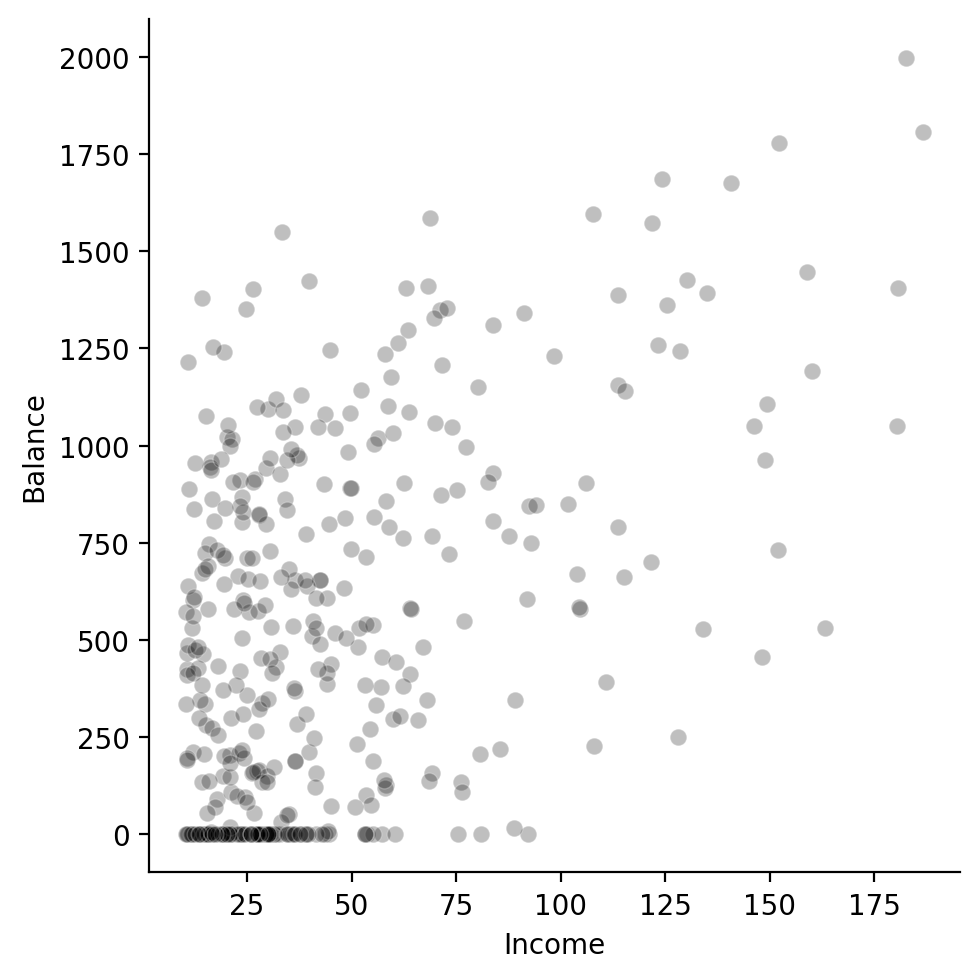

In [3]:
sns.relplot(
    data=df,
    x='Income',
    y='Balance',
    color='black',
    alpha=.25,
)

We can see there does seem to be some kind of relationship: as income increases so does balance.  
There's also some interesting observations at the lower end of income let's zoom into those.  
I'll first filter the data to Incomes < 50 and then create another scatter plot + a histogram

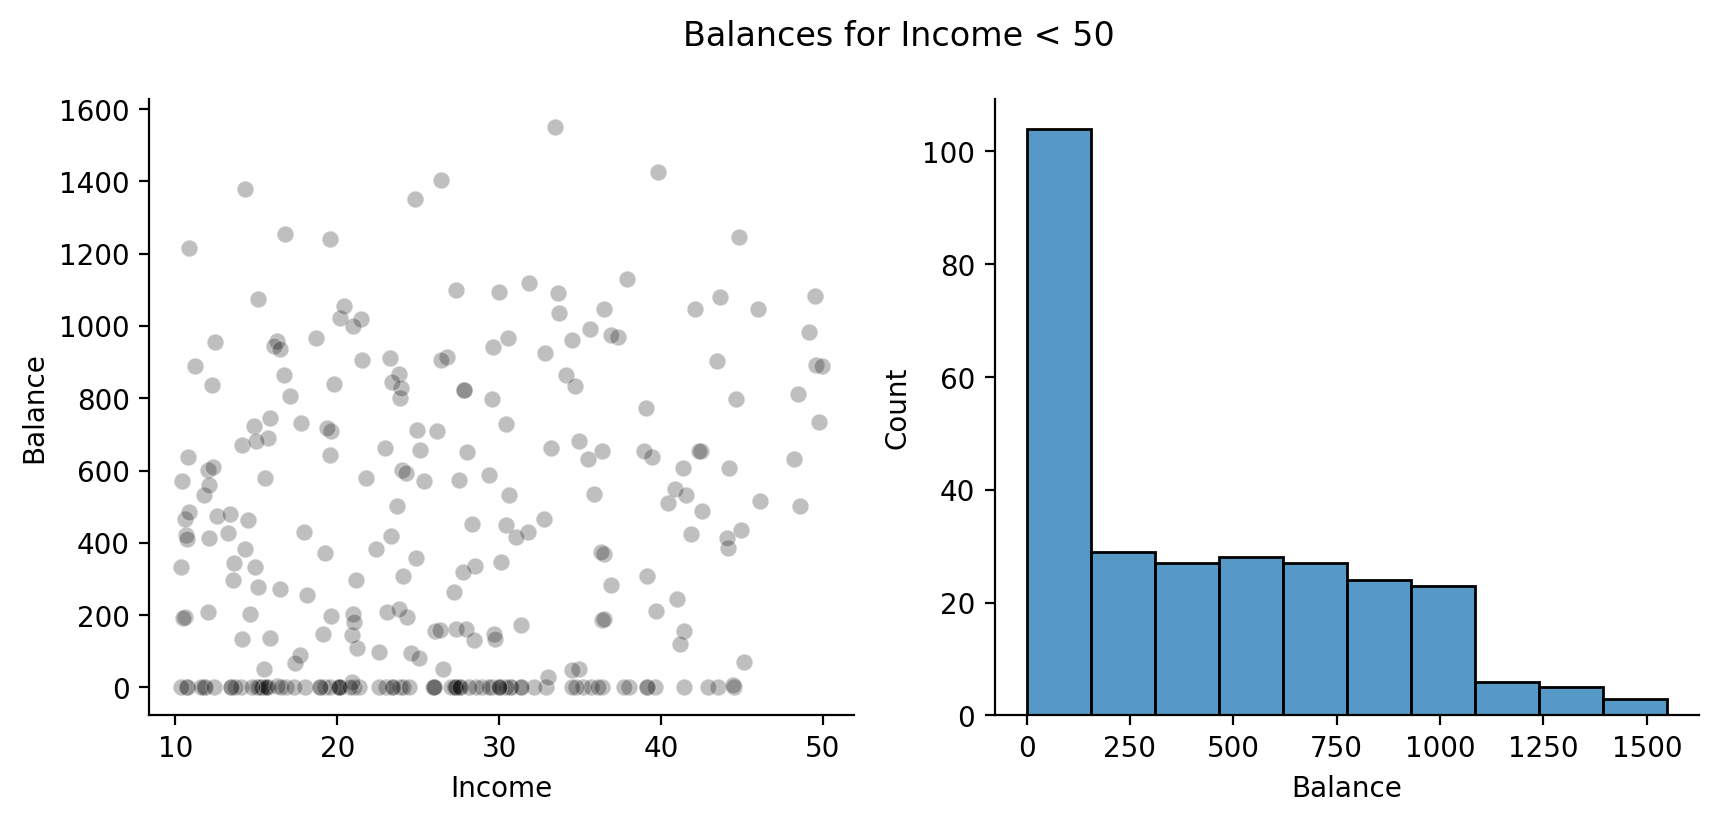

In [4]:
# Filter rows and only select 3 columns
df_lt_50 = df.filter(col('Income') < 50).select(['Index', 'Income','Balance'])

# Create 1 x 2 figure
f, axs = plt.subplots(1,2, figsize=(10,4))

# Left
sns.scatterplot(
    data=df_lt_50,
    x='Income',
    y='Balance',
    color='black',
    alpha =.25,
    ax=axs[0]
)

# Right
sns.histplot(df_lt_50, x='Balance', ax=axs[1]);

# Remove top and right spines
sns.despine();

# Add overall title
f.suptitle('Balances for Income < 50');

Ah, we can see that for a large number of people with Incomes below this threshold they carry a **Balance** of $0!  
Let's keep this mind as we fit our model and interpret the results.

Next let's ask `seaborn` to add in a regression line using the original data.  
This gives us an indication of how well our model will do before we use `statsmodels`.  
In fact, `seaborn` *uses* `statsmodels` under-the-hood to do regression!

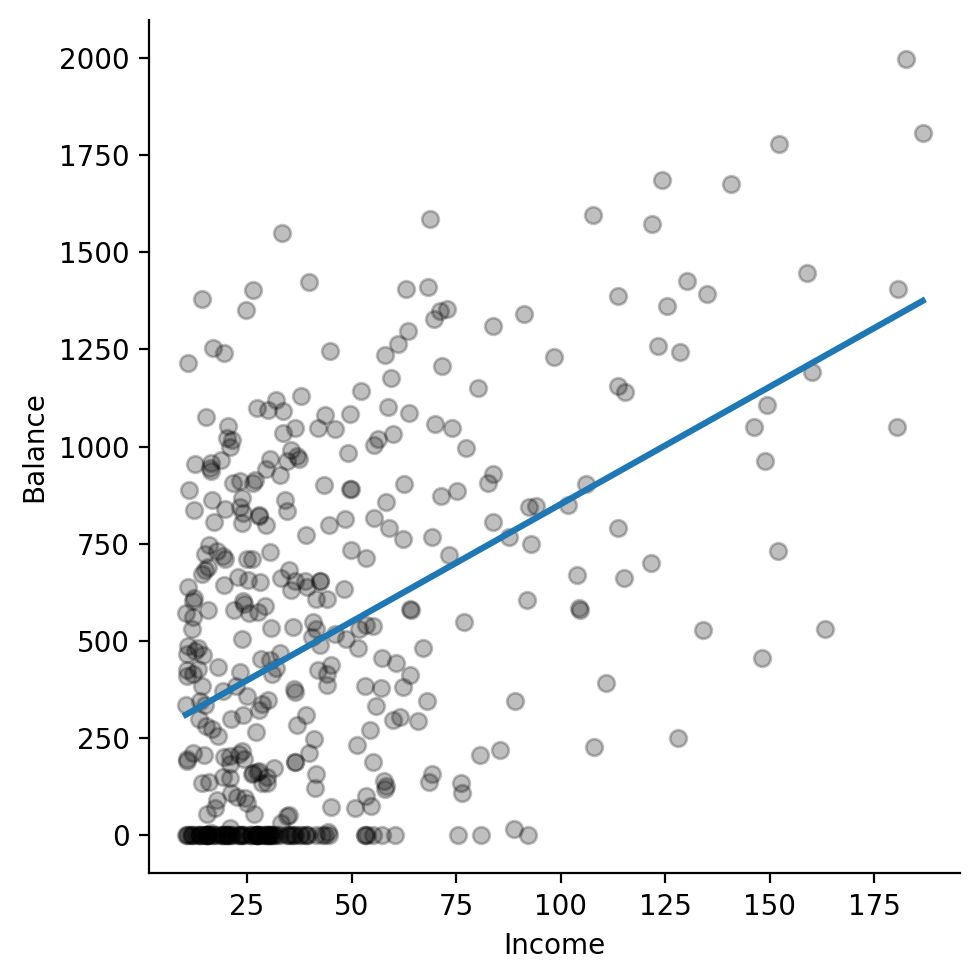

In [5]:
sns.lmplot(
    data=df, # original data
    x='Income',
    y='Balance',
    fit_reg=True,
    ci=None, # no confidence intervals
    scatter_kws={'color':'black', 'alpha':.25}, # match color scatterplots
)

Ok this is promising and verifies out visual intuitions about an increasing linear relationship. Let's go ahead and estimate a model ourselves!

## 1. Model estimation

We can start by importing the `ols` function from `statsmodels`:

In [6]:
from statsmodels.formula.api import ols

This function takes 2 arguments:

- `formula`: a Python string that specifies the model using formula-syntax similar to R's `lm()` function
- `data`: a Pandas DataFrame that contains the data; we can convert our `polars` DataFrame to a Pandas DataFrame using `.to_pandas()`


### A note on using model "formulas"

Wilkinson Notation, i.e. "formula syntax" was [popularized by R](https://www.econometrics.blog/post/the-r-formula-cheatsheet/) and provides a succinct way to specify models.  
`statsmodels` supports [*mostly* the same syntax](https://www.statsmodels.org/stable/example_formulas.html) but there are a [few differences](https://patsy.readthedocs.io/en/latest/R-comparison.html) you should be aware of in-case you're trying to translate things 1-to-1

We'll try to add any formula quirks to the course-website, but for now this reference should get you going:

| Formula   | Description                     |
|------------|---------------------------------|
| `y ~ 1`    | intercept only             |
| `y ~ x1`   | intercept and x1                |
| `y ~ 0 + x1` | only x1 without intercept                   |
| `y ~ np.log(x1)`   | intercept and log-transformed x1                |
| `y ~ center(x1)`   | intercept and mean-centered x1                |
| `y ~ standardize(x1)`   | intercept and z-scored x1                |
| `y ~ x1 + x2`      | intercept, x1, and x2          |
| `y ~ x1 + x2+ x1:x2`     | intercept, x1, x2, and their interaction                        |
| `y ~ x1*x2`  | short-hand for previous              |
| `y ~ x1 + x1**2`      | intercept, x1, and x2 squared                  | 


Let's use this syntax to define our model. `statsmodels` works best with Pandas dataframes so make to call `.to_pandas()` on your dataframe before passing it to `ols`:

In [7]:
model = ols('Balance ~ Income', data=df.to_pandas())

Remember that whenever we use formula syntax, both R and Python will automatically add an intercept term for us. In other words, the following formulas are equivalent:

- `Balance ~ 1 + Income`
- `Balance ~ Income`

### Key model attributes

The `model` variable we created is a `statsmodels` OLS model that has 2 key attributes you'll want to know how to access:

1. `model.exog`: the $X$ design matrix of the model
2. `model.endog`: the $y$ vector of observations of the dependent variable

*Note `statsmodels` was developed in an econometrics tradition where [$X$ is referred to as the "exogenous" variable and $y$ is referred to as the "endogenous" variable](https://www.statsmodels.org/stable/endog_exog.html).*


We can see that our **design matrix** contains a column for the intercept $\beta_0$ and column for our single predictor $\beta_1$ **Income**:

In [8]:
# First 3 rows of design matrix
model.exog[:3, :]

array([[  1.   ,  14.891],
       [  1.   , 106.025],
       [  1.   , 104.593]])

And that our $y$ vector is just the column of our dependent variable values

In [9]:
# Numpy function to compare two arrays each element at a time
np.allclose(
    model.endog,
    df['Balance'].to_numpy()
)

True

### Fitting the model

To actually estimate our model, we can use its `.fit()` method and save the output to a new variable

In [10]:
results = model.fit()

results

### Key Estimation Attributes

The output of `.fit()` is a [`RegressionResults`](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html#statsmodels.regression.linear_model.RegressionResults) object that has lots of methods and attributes referenced in the linked documentation.

For now let's just focus on a few of you're most likely to use:

- `results.params`: the estimated $\hat{\beta}$ coefficients
- `results.fittedvalues`: the predicted values $\hat{y}_i$
- `results.resid`: the residuals $y_i - \hat{y}_i$
- `results.ssr`: the sum of the squared residuals $\sum_{i=1}^n (y_i - \hat{y}_i)^2$

Let's look at the parameter estimates

In [11]:
# Betas - estimated coefficients
results.params

Intercept    246.514751
Income         6.048363
dtype: float64

We can get each one by name by *slicing*

In [12]:
results.params['Intercept']

np.float64(246.51475059140336)

In [13]:
results.params['Income']

np.float64(6.048363408531563)

And the model's predictions of our dependent variable ($\hat{y}$), in this case $\hat{Balance}$.

In [14]:
# Predicted values of Balance
results.fittedvalues

0       336.580930
1       887.792481
2       879.131225
3      1147.261223
4       584.509395
          ...     
395     319.675754
396     327.345079
397     596.545638
398     474.707405
399     359.625195
Length: 400, dtype: float64

This is a Pandas Series (single DataFrame column) by default so it can be helpful to convert it to a `numpy` array for future operations:

In [15]:
yhats = results.fittedvalues.to_numpy()

And we can also get the model **residuals** or differennce between the observed and predicted values:

$$ residual_i = y_i - \hat{y}_i $$

In [16]:
results.resid

0       -3.580930
1       15.207519
2     -299.131225
3     -183.261223
4     -253.509395
          ...    
395    240.324246
396    152.654921
397   -458.545638
398   -474.707405
399    606.374805
Length: 400, dtype: float64

Which is the same thing as:

In [17]:
df['Balance'].to_numpy() - results.fittedvalues

0       -3.580930
1       15.207519
2     -299.131225
3     -183.261223
4     -253.509395
          ...    
395    240.324246
396    152.654921
397   -458.545638
398   -474.707405
399    606.374805
Length: 400, dtype: float64

We can similarily convert this DataFrame column to a `numpy` array:

In [18]:
residuals = results.resid.to_numpy()

`statsmodels` also gives us the SSE of the model, which it calls the sum-of-the-squared-residuals (SSR):

In [19]:
# Sum of squared residuals
results.ssr

np.float64(66208744.51078422)

Which we can manually verify ourselves:

In [20]:
np.sum(results.resid ** 2) 

np.float64(66208744.51078422)

## 2. Interpreting Parameter Estimates

Let's take a look at the estimated $\beta$ values and try to understand what they mean

In [21]:
results.params

Intercept    246.514751
Income         6.048363
dtype: float64

Let's take a look back at the plot we made earlier to understand exactly what these estimates refer to

<div align="center">
<img src="./figs/lmplot.png" width="50%" alt="Figure 1">
</div>

In natural language we would state:

"*For each additional thousand dollars of income, a person's average credit card debt is expected to increased b $6.05*"

Wait a minute I thought the **Intercept** was always the *mean* of $y$, what gives?



### What parameters mean

The key lesson to remember when interpeting parameter estimates from *any* GLM is:

The expected change in $y$ for 1-unit of change in $x_i$ **when all other model parameters are fixed at 0**, this is when $x_{not\ i} = 0$.  

In other words, our Intercept value of $246.5$ is our prediction for $\hat{Balance}$ when $Income = 0$ !

Does this make sense for an estimate we want? More importantly **is this even in the range of the observed data**?


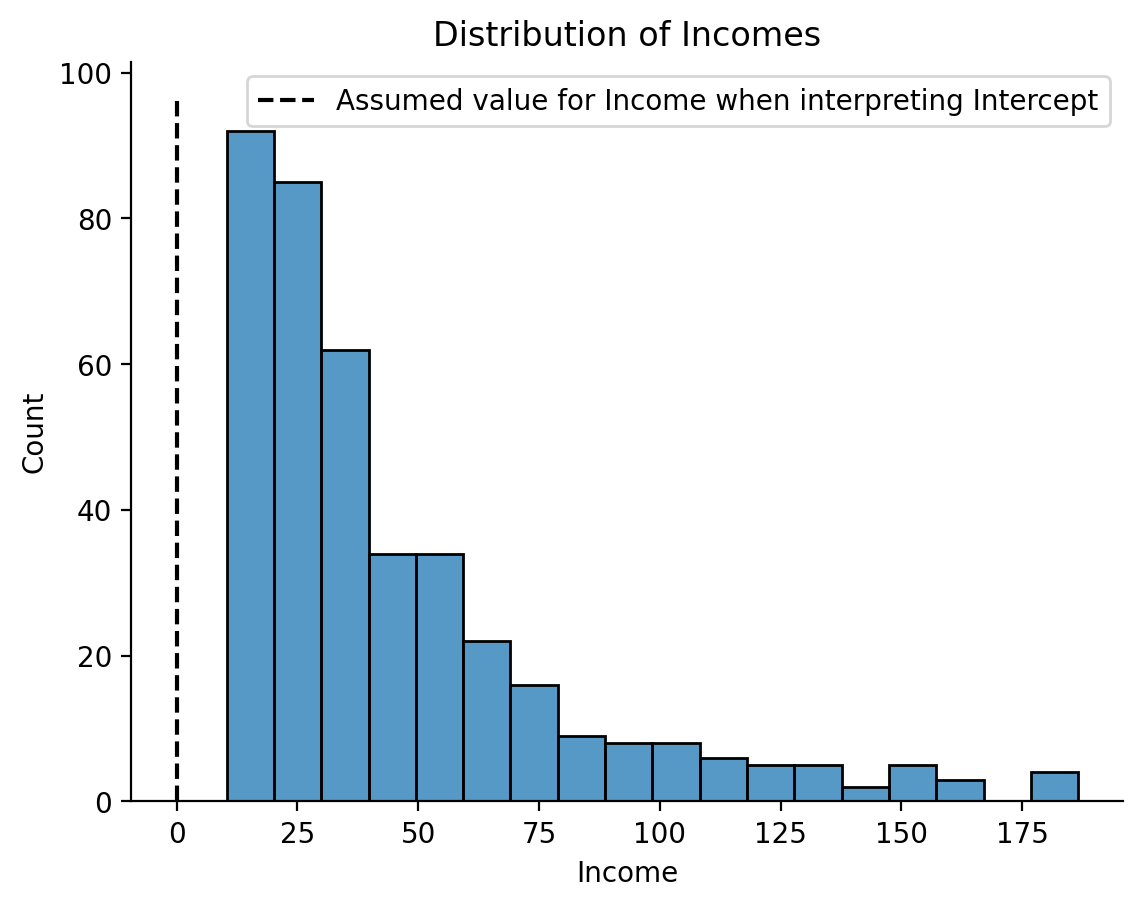

In [22]:
ax = sns.histplot(df['Income']);
ax.vlines(x=0, ymin=0, ymax=ax.get_ylim()[-1], ls='--', color='k', label='Assumed value for Income when interpreting Intercept');
ax.set(xlabel='Income', title='Distribution of Incomes')
plt.legend();
sns.despine();

In this case, interpreting our **Intercept** parameter is essentially meaningless because we never actually observed an individual with an Income of 0!  
The take-away here is the models will happily **make predictions outside the range of your data** but often times this isn't what you want!

### Improving interpretations with centering

What we really want is for our model to estimate an **Intercept** that assumes **Income** is fixed at some *reasonable value* that we measured. How can we do this?  
Easy! We can just *center* our predictor around some meaningful value by subtracting it from each data-point.  
Most commonly, you'll want to **mean-center** your predictors - which makes the **Intercept** more interpretable!  

Let's try it out and see what happens. Let's add a mean-centered **Income** column to our dataframe:

In [23]:
df = df.with_columns(
    Income_centered = col('Income') - col('Income').mean(),
)
df

Index,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Income_centered
i64,f64,i64,i64,i64,i64,i64,str,str,str,str,i64,f64
1,14.891,3606,283,2,34,11,"""Male""","""No""","""Yes""","""Caucasian""",333,-30.327885
2,106.025,6645,483,3,82,15,"""Female""","""Yes""","""Yes""","""Asian""",903,60.806115
3,104.593,7075,514,4,71,11,"""Male""","""No""","""No""","""Asian""",580,59.374115
4,148.924,9504,681,3,36,11,"""Female""","""No""","""No""","""Asian""",964,103.705115
5,55.882,4897,357,2,68,16,"""Male""","""No""","""Yes""","""Caucasian""",331,10.663115
…,…,…,…,…,…,…,…,…,…,…,…,…
396,12.096,4100,307,3,32,13,"""Male""","""No""","""Yes""","""Caucasian""",560,-33.122885
397,13.364,3838,296,5,65,17,"""Male""","""No""","""No""","""African American""",480,-31.854885
398,57.872,4171,321,5,67,12,"""Female""","""No""","""Yes""","""Caucasian""",138,12.653115


Then let's estimate a new model with this column and look at its parameter estimates:

In [24]:
model_centered = ols('Balance ~ Income_centered', data=df.to_pandas())
results_centered = model_centered.fit()

results_centered.params

Intercept          520.015000
Income_centered      6.048363
dtype: float64

Wow the Intercept changed! What's going on? How about a visual inspection with `seaborn`?

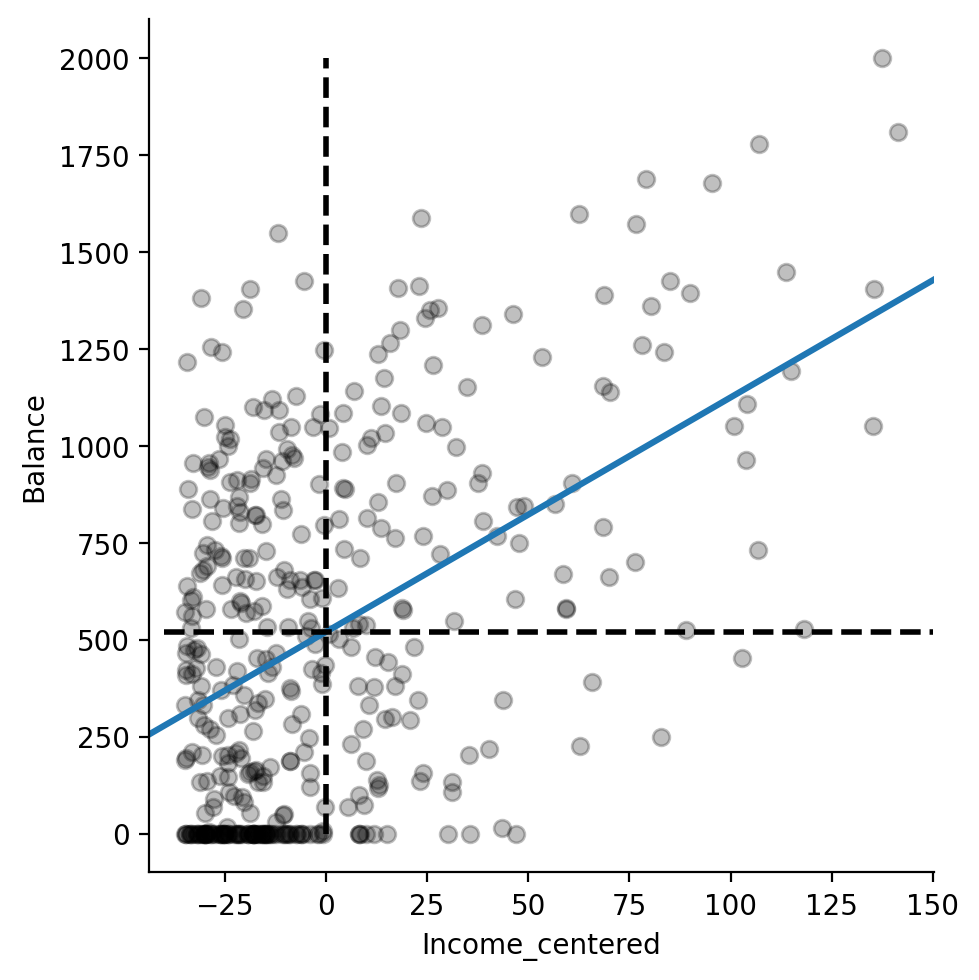

In [25]:
grid = sns.lmplot(
    data=df,
    x='Income_centered',
    y='Balance',
    fit_reg=True,
    ci=None,
    scatter_kws={'color':'black', 'alpha':.25},
    truncate=False
)
grid.ax.vlines(0, 0, 2000, linestyle='--', color='black', lw=2)
grid.ax.hlines(520, -40, 150, linestyle='--', color='black', lw=2)

I've added dashed black lines to the figure to illustrate the effect of centering **Income**.  
From the perspective of the model, $\beta_0$ is now the estimate of the **Intercept** when **Income** is held constant at its **mean value**.  
If we draw a vertical line at the new mean of **Income_centered**, i.e. 0 we can see where it *intercepts* the regression line.  
This *is* our new estimated $\beta_0 = 520.015$ !

And just to verify that this is indeed the mean of $y$, let's just calculate it:

In [26]:
df.select(
    col('Balance', 'Income', 'Income_centered').mean()
)

Balance,Income,Income_centered
f64,f64,f64
520.015,45.218885,-7.1054e-17


### Easy centering with `statsmodels` formulas

We can actually do this very easily in `statsmodels` *without* having to create a DataFrame column by using `center` inside our formula.  

This is a special operation `statsmodels` understands that saves us time. Below I'm not saving any outputs or the model itself but just printing the estimated parameters so you can see that they're the same as before:

In [27]:
ols('Balance ~ center(Income)', data=df.to_pandas()).fit().params

Intercept         520.015000
center(Income)      6.048363
dtype: float64

### Take aways about centering

We'll discuss centering more when we look at *multiple regression* in a later notebook, but for now here are some key take-aways:

- Centering is a way to fix a parameter estimate at some value (e.g. mean) to aid in the interpretation of *other parameter estimates* 
- Centering never changes the parameter estimate of the variable *being centered*
- It only changes the value of *other parameter estimates*
- You should *almost always* consider centering your continuous variable unless a value of 0 is of theoretical interest!
- Centering is *incredibly important* in multiple regression with interactions, but we'll cover this in the future

## 3. Model Evaluation

`statsmodels` has made it pretty easy to estimate a model, but before we make strong conclusions about our parameter estimates, we should always at least visually inspect that we're not violating the course assumptions of the GLM: **independent and identitically distributed (iid) errors**. 

We can do this by inspecting the **residuals** from our model and looking for any structure in the errors that our model makes.

Let's do this in 3 ways:

1. We'll start by looking at the distribution of residuals using a historgram and QQplot and checking they're approximately normal (they should be)
2. We'll plot the residuals against the predictor variable **Income** looking for any structure in how the *errors vary with the predictor* (they shouldn't)
3. We'll look at the residuals against the true value of **Balance** looking for any values our dependent variable that are particulary mis-predicted by our model


Let's start by adding columns that contain the residuals to our DataFrame to make plotting easier

In [28]:
df = df.with_columns(
    residuals = results.resid.to_numpy(),
    residuals_centered = results_centered.resid.to_numpy(),
)
df.head()

Index,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Income_centered,residuals,residuals_centered
i64,f64,i64,i64,i64,i64,i64,str,str,str,str,i64,f64,f64,f64
1,14.891,3606,283,2,34,11,"""Male""","""No""","""Yes""","""Caucasian""",333,-30.327885,-3.58093,-3.58093
2,106.025,6645,483,3,82,15,"""Female""","""Yes""","""Yes""","""Asian""",903,60.806115,15.207519,15.207519
3,104.593,7075,514,4,71,11,"""Male""","""No""","""No""","""Asian""",580,59.374115,-299.131225,-299.131225
4,148.924,9504,681,3,36,11,"""Female""","""No""","""No""","""Asian""",964,103.705115,-183.261223,-183.261223
5,55.882,4897,357,2,68,16,"""Male""","""No""","""Yes""","""Caucasian""",331,10.663115,-253.509395,-253.509395


### Distrubtion of Residuals

#### Residual Histograms

We can see that the residuals are approximately normal, but there's a peak between -500 and -250.

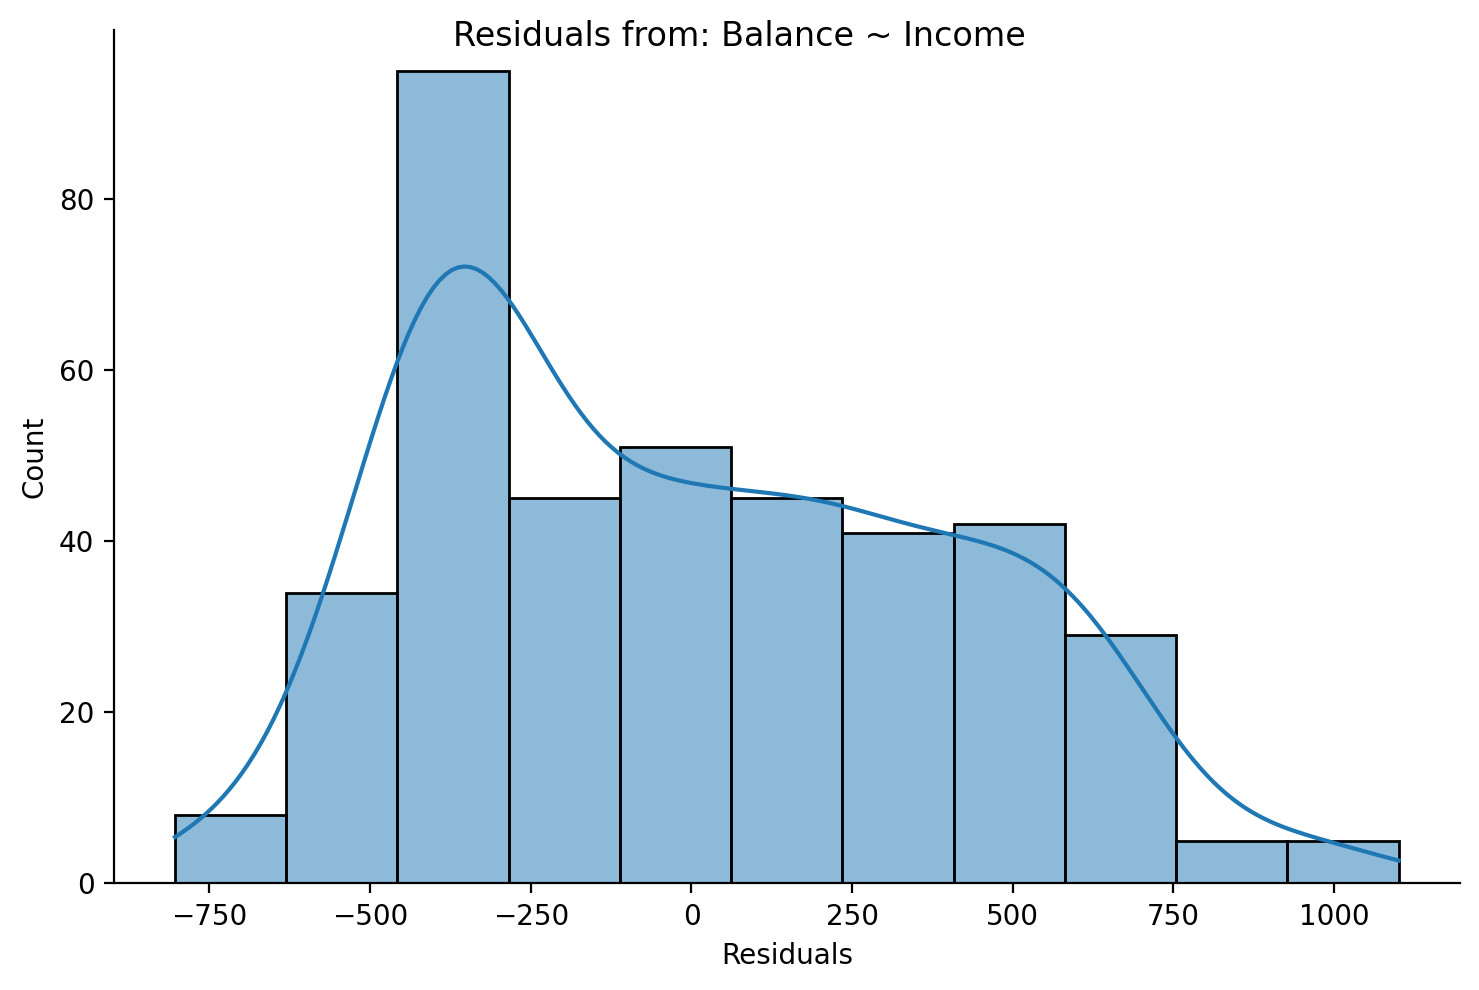

In [29]:
grid = sns.displot(data=df,x='residuals',height=5,aspect=1.5, kde=True)
grid.set_axis_labels('Residuals','Count');
grid.figure.suptitle('Residuals from: Balance ~ Income');

This is also true if we plot the residuals from our centered model because centering *doesn't change the prediction accuracy* of a model!

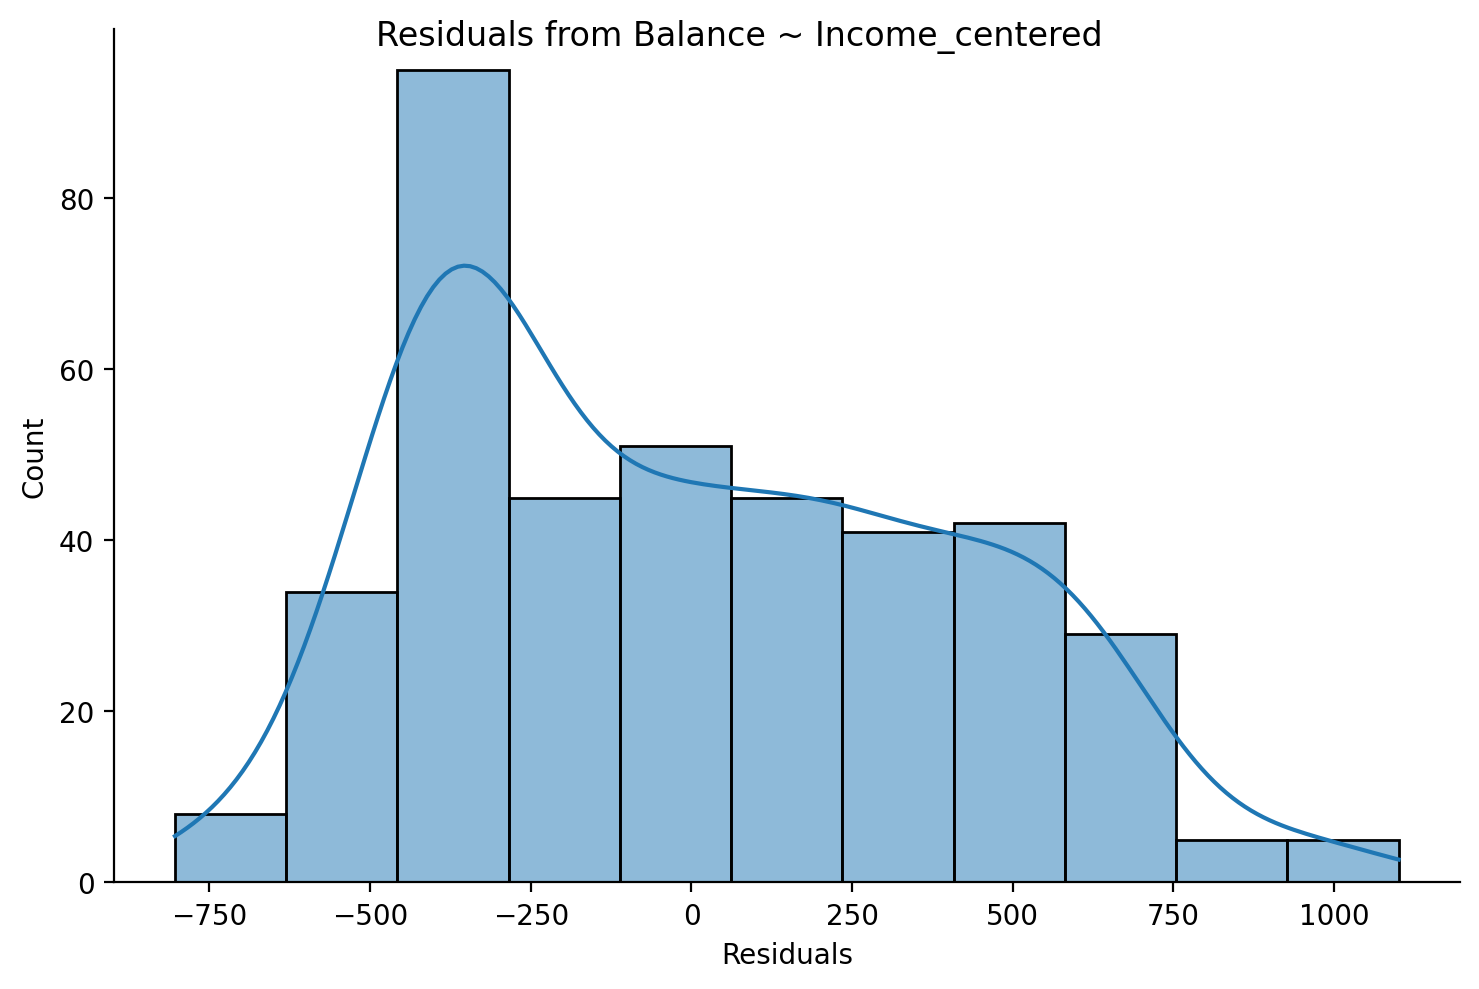

In [30]:
grid = sns.displot(data=df,x='residuals_centered',height=5,aspect=1.5, kde=True)
grid.set_axis_labels('Residuals','Count');
grid.figure.suptitle('Residuals from Balance ~ Income_centered');

#### Residual QQPlots
Another useful way to examine the distribution of your residuals that can supplement a histogram is a QQ plot.  
This is a plot of the quantiles of the residuals against the theoretical quantiles of a standard normal distribution.  

We can do this using the `qqplot` function from `statsmodels` which takes DataFrame column or array of residuals as input. The `line = s` tells `qqplot` to add in a red identity line across standard normal quantiles.

If our residuals were *perfectly* normally distributed, then they would lie right on the red identity line.  
Deviations above or below the line tell you how far away from normality the residuals are.  

Overall, this QQplot looks pretty good. But we can see that towards the low end of data values, it veers upwards - similar to the spike we saw in the histogram.  


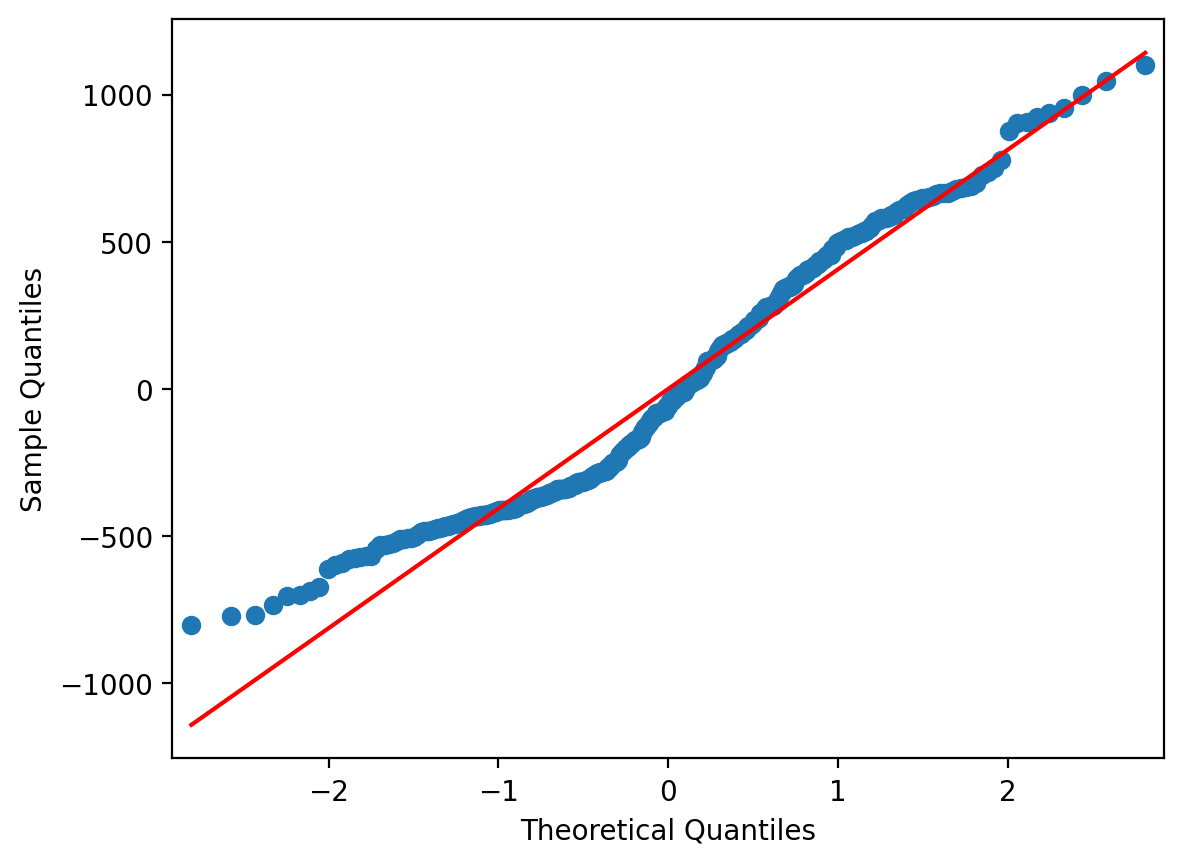

In [31]:
# Import it 
from statsmodels.graphics.gofplots import qqplot

# Pass it the column that contains the residuals
qqplot(df['residuals'], line = 's');

Sometimes it's helpful to see the *standardized residuals* instead, especially if you wanted to compare QQplots with different scales. 

To do so we can use the `results` from our `model.fit()` and call the `.get_influence()` method on it. This returns a few different things, but we care about `.resid_studentized`, which converts our residuals to an approximately standard-deviation scale.

In this case the QQplot looks pretty much the same, but notice how the y-axis is now in units of standard-deviation instead of raw data:


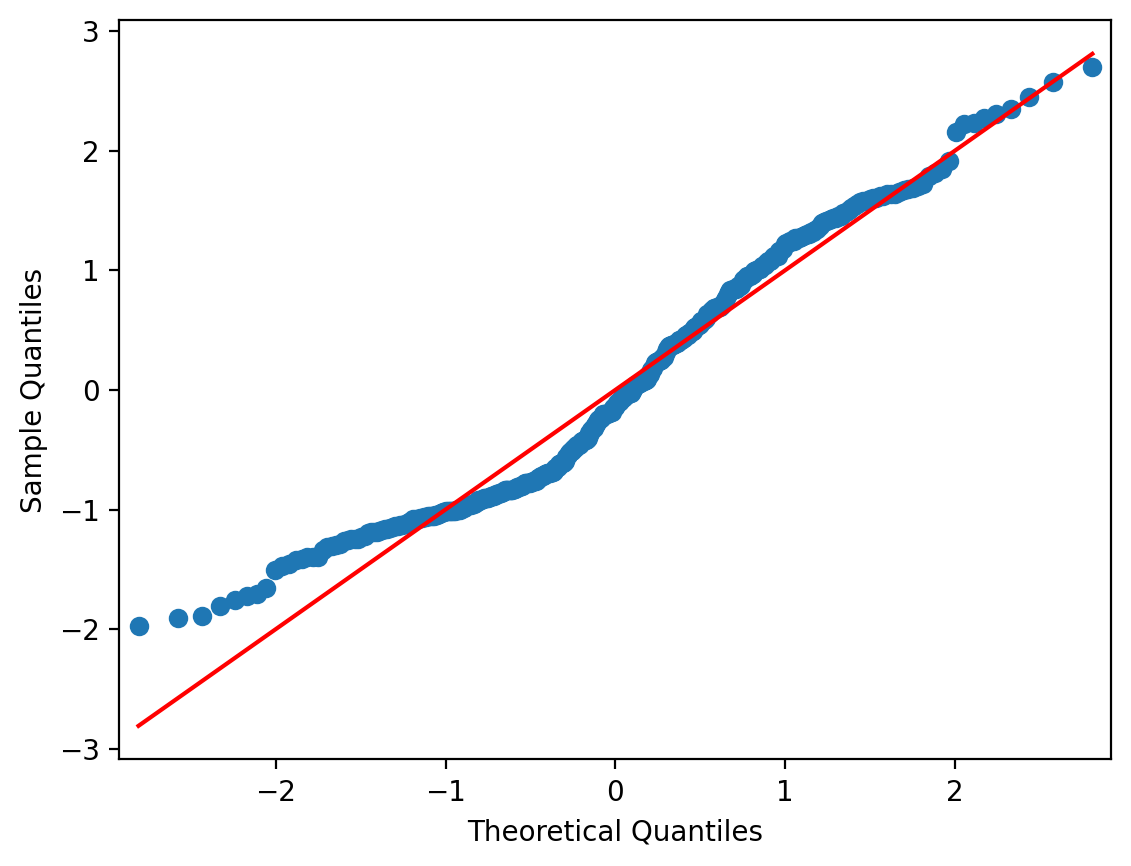

In [32]:
# Standardized are sometimes easier to compare across models
qqplot(results.get_influence().resid_studentized, line = 's');

### Residuals and Predictors
#### Residual Scatterplots

Let's see if we can figure out what that peak is. It might help to plot the residuals against the predictor $X$ **Income**

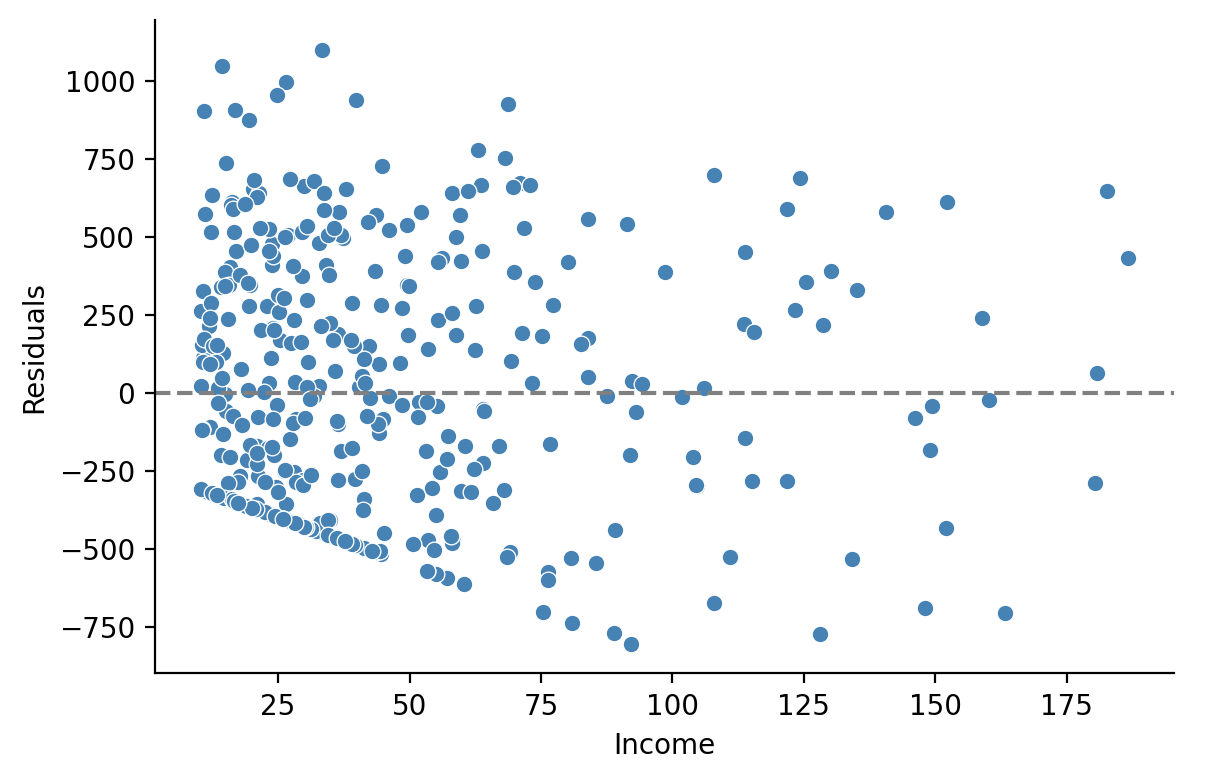

In [33]:
grid = sns.FacetGrid(data=df, height=4,aspect=1.5)

# Residuals vs Income
grid.map(sns.scatterplot, 'Income', 'residuals', color='steelblue');

# Horizontal line at 0
grid.map(plt.axhline, y=0, color='gray', linestyle='--');

# Labels and legend
grid.set_axis_labels('Income', 'Residuals');
grid.add_legend();

Indeed we can see that most of the error in our model is coming from the mis-predicted observations from people with an $Income < 50$

Since so many people below this threshold carry a **Balance** of $0, there's no *variance* in the $y$ values our model observes and therefore it can't incorporate this into the parameter estimates!

Our errors are therefore due to a lack of variance in that region of the data itself!

#### Note on `sns.residplot`

`seaborn` offers a handy axis-level function called [`sns.residplot`](https://seaborn.pydata.org/generated/seaborn.residplot.html) that can be used to plot residuals even before you've fitted a model. 

It can be handy for exploring simple univariate regression models because `seaborn` will automatically estimate an `ols` model and calculate the residuals for you give the column that corresponds to your $X$ variable and a column that corresponds to your $y$ variable.

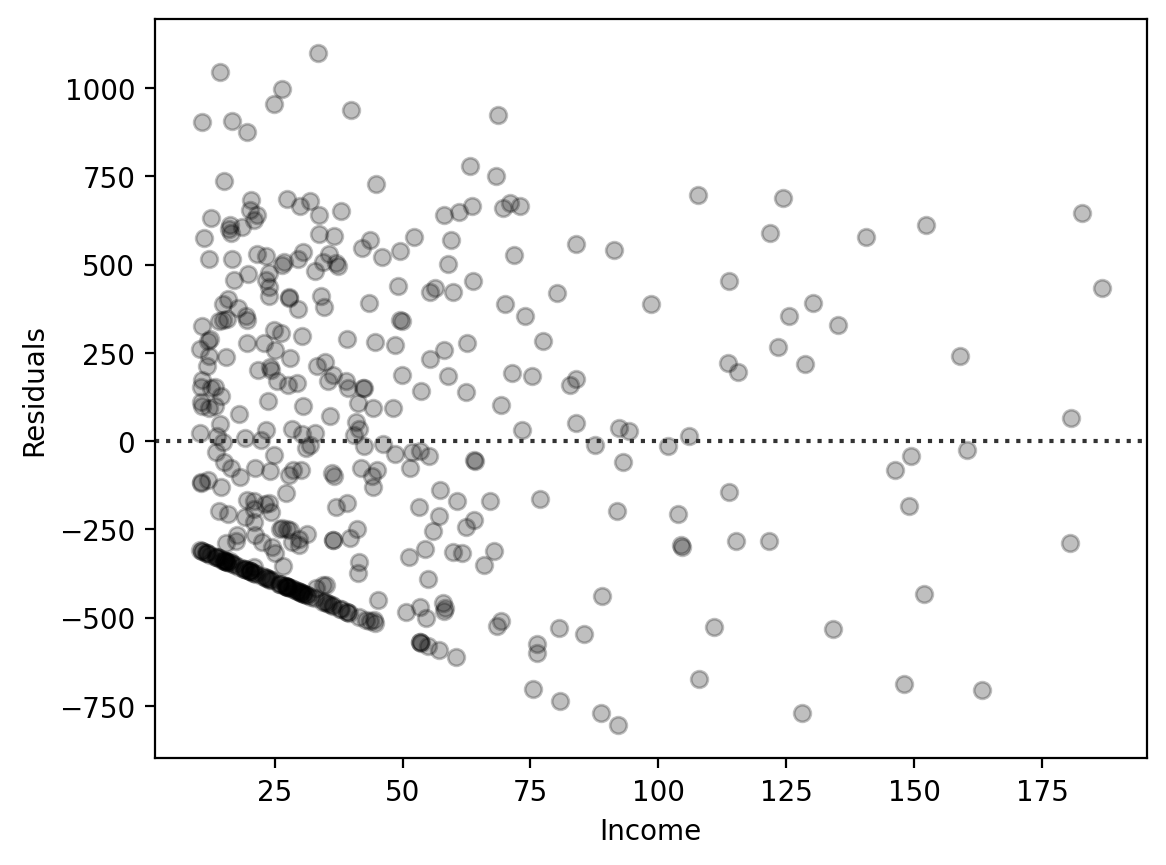

In [34]:
ax = sns.residplot(
    data=df,
    x='Income',
    y='Balance', # Give it the column of the DV directly!
    scatter_kws={'color':'black', 'alpha':.25},
)

ax.set(xlabel='Income', ylabel='Residuals');

In general thought, I find `sns.residplot` a bit in-flexible and prefer to create my own figures using other `seaborn` functions by adding columns to my DataFrame and plotting those like we did before.

### Residuals and Outcomes
#### Inspecting Model Predictions

Finally it's always a good idea to plot the predictions of our model $\hat{Balance}$ against our observed values of $Balance$.  
Let's add a column to our DataFrame and visualize the relationship

In [35]:
df = df.with_columns(
    Balance_predictions = results.fittedvalues.to_numpy()
)
df.head()

Index,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Income_centered,residuals,residuals_centered,Balance_predictions
i64,f64,i64,i64,i64,i64,i64,str,str,str,str,i64,f64,f64,f64,f64
1,14.891,3606,283,2,34,11,"""Male""","""No""","""Yes""","""Caucasian""",333,-30.327885,-3.58093,-3.58093,336.58093
2,106.025,6645,483,3,82,15,"""Female""","""Yes""","""Yes""","""Asian""",903,60.806115,15.207519,15.207519,887.792481
3,104.593,7075,514,4,71,11,"""Male""","""No""","""No""","""Asian""",580,59.374115,-299.131225,-299.131225,879.131225
4,148.924,9504,681,3,36,11,"""Female""","""No""","""No""","""Asian""",964,103.705115,-183.261223,-183.261223,1147.261223
5,55.882,4897,357,2,68,16,"""Male""","""No""","""Yes""","""Caucasian""",331,10.663115,-253.509395,-253.509395,584.509395


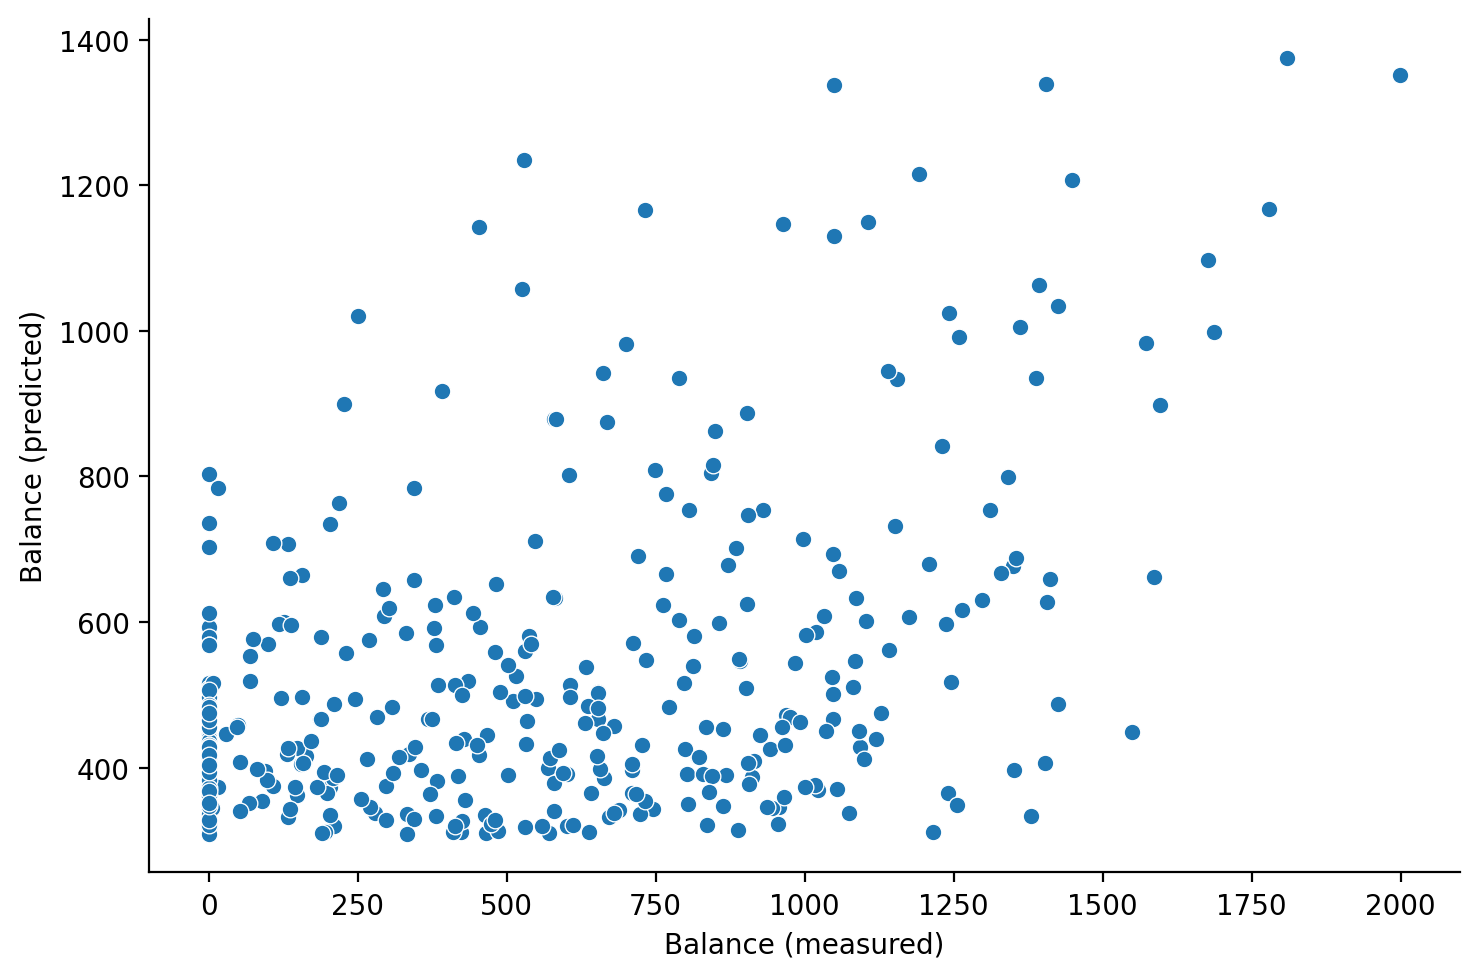

In [36]:
grid = sns.relplot(
    data=df,
    x="Balance",
    y="Balance_predictions",
    kind='scatter',
    height=5,
    aspect=1.5,
)

# Labels and legend
grid.set_axis_labels('Balance (measured)', 'Balance (predicted)');


#### Coefficient of Determination ($R^2$)

We can quantify the quality of our predictions by calculating the **coefficient of determination**.

The coefficient of determination, often denoted as $R^2$, measures the proportion of variance in the dependent variable that is predictable from the independent variable(s).

$$ R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}} $$

Where:
- $SS_{\text{res}}$ is the residual sum of squares, $e^Te$.
- $SS_{\text{tot}}$ is the total sum of squares, adjusting for the mean, $(y-\bar{y})^T(y-\bar{y})$.

A value of $R^2$ close to 1 suggests that a large proportion of the variability in the outcome has been explained by the regression model.  
A value close to 0 indicates the model is missing a large amount of variability in the outcome  
A value *below* 0 indicates the model is *systematically* mis-predicting in some way

We can use the handy `r2_score` function from the `sklearn` library to calculate this for us. We haven't discussed this library yet, but we'll come back to it later.

`r2_score` takes in two arguments:
- `y_true`: the true values of the dependent variable
- `y_pred`: the predicted values of the dependent variable


In [37]:
from sklearn.metrics import r2_score

r2_score(df['Balance'].to_numpy(), df['Balance_predictions'].to_numpy())

0.21497731013240484

And in fact we can see that this matches the output that `statsmodels` gives us in its `.rsquared` attribute:

In [38]:
results.rsquared

np.float64(0.21497731013240484)

### Challenge: Inspect models of Anscombe's Quartet

In the following cell we've loaded Anscombe's quarted for you into a DataFrame.

In [39]:
anscombe = pl.DataFrame(sns.load_dataset('anscombe')) 
anscombe

dataset,x,y
str,f64,f64
"""I""",10.0,8.04
"""I""",8.0,6.95
"""I""",13.0,7.58
"""I""",9.0,8.81
"""I""",11.0,8.33
…,…,…
"""IV""",8.0,5.25
"""IV""",19.0,12.5
"""IV""",8.0,5.56


1) Using `.filter()` in polars, create 4 new dataframes, one per dataset, and fit 4 separate `ols` models


In [40]:
# Your code here
df1 = anscombe.filter(col('dataset') == "I")
df2 = anscombe.filter(col('dataset') == "II")
df3 = anscombe.filter(col('dataset') == "III")
df4 = anscombe.filter(col('dataset') == "IV")

In [41]:
# Your code here
m1 = ols('y ~ x', data=df1.to_pandas())
m1r = m1.fit()

m2 = ols('y ~ x', data=df2.to_pandas())
m2r = m2.fit()

m3 = ols('y ~ x', data=df3.to_pandas())
m3r = m3.fit()

m4 = ols('y ~ x', data=df4.to_pandas())
m4r = m4.fit()

2. Visualize the residuals of each model using a `qqplot` 

    How do these compare to plots of the original data?

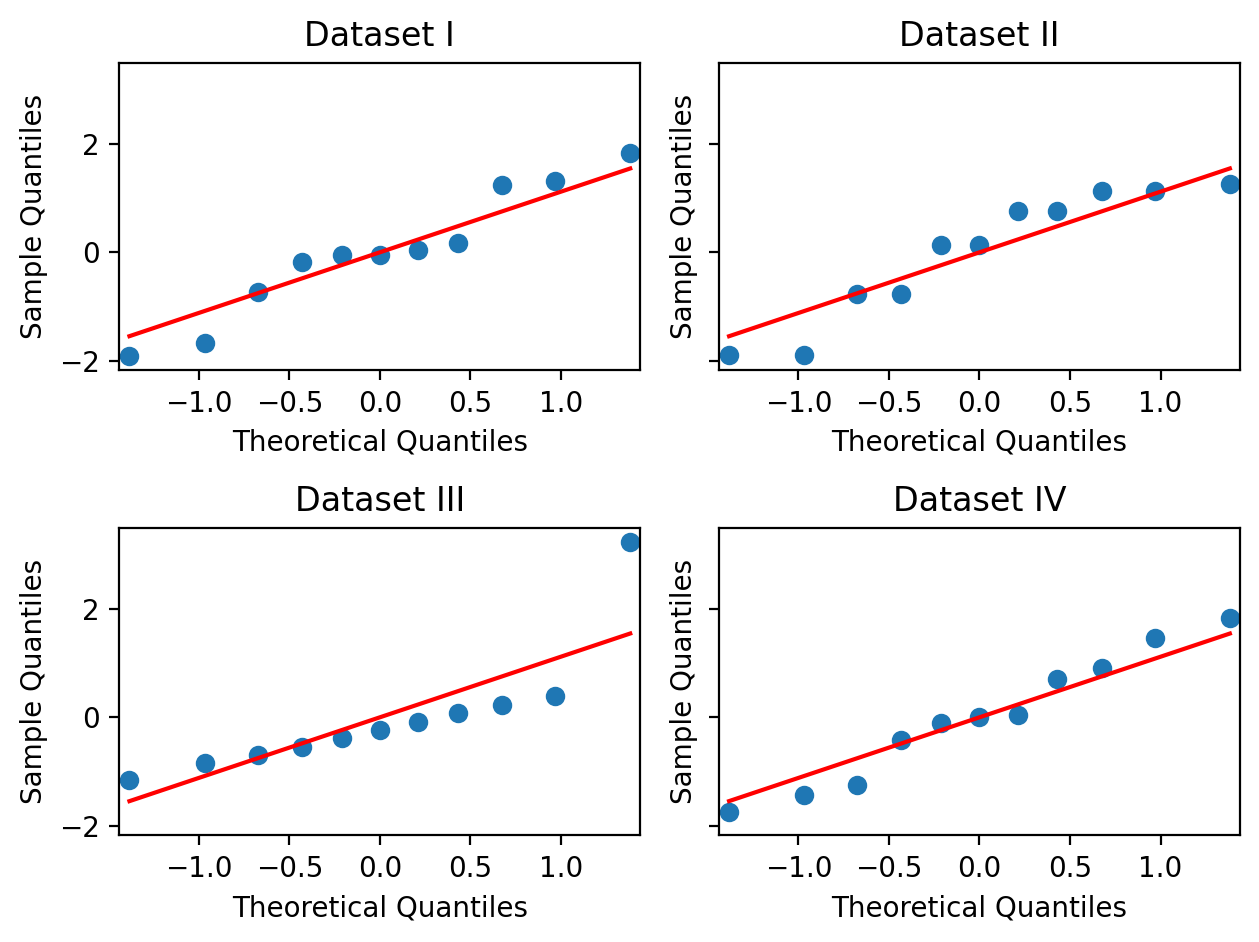

In [42]:
# Your code here
f, axs = plt.subplots(2,2, sharey=True, sharex=False)

# Assign to throw-away variable _ to prevent double plotting
_ = qqplot(m1r.resid, line='s',ax=axs[0,0]);
axs[0,0].set_title('Dataset I');

_ = qqplot(m2r.resid, line='s',ax=axs[0,1]);
axs[0,1].set_title('Dataset II');

_ = qqplot(m3r.resid, line='s',ax=axs[1,0]);
axs[1,0].set_title('Dataset III');

_ = qqplot(m4r.resid, line='s',ax=axs[1,1]);
axs[1,1].set_title('Dataset IV');

# Make sure stuff doesn't overlap!
plt.tight_layout();

Here's a way we can do this using `FacetGrid` and a custom `qqplot_custom` based on [this example](https://seaborn.pydata.org/tutorial/axis_grids.html#using-custom-functions) from the seaborn website.


In [47]:
# First we define a custom function to make a qqplot
def qqplot_custom(x, **kwargs):
    from scipy import stats

    # Calculate quantiles using probplot
    quantiles, xr = stats.probplot(x, fit=False)

    # Make a scatterplot
    plt.scatter(quantiles, xr, **kwargs)

    # Plot the unity line
    plt.axline((-2,-2), slope=1., color='k');


Then let's concatenate all our models' residuals into a numpy array and save it as a new column our original DataFrame:

In [48]:
anscombe = anscombe.with_columns(
    residuals = np.concatenate([
                            m1r.resid,
                            m2r.resid,
                            m3r.resid,
                            m4r.resid])
)
anscombe

dataset,x,y,residuals
str,f64,f64,f64
"""I""",10.0,8.04,0.039
"""I""",8.0,6.95,-0.050818
"""I""",13.0,7.58,-1.921273
"""I""",9.0,8.81,1.309091
"""I""",11.0,8.33,-0.171091
…,…,…,…
"""IV""",8.0,5.25,-1.751
"""IV""",19.0,12.5,-5.3291e-15
"""IV""",8.0,5.56,-1.441


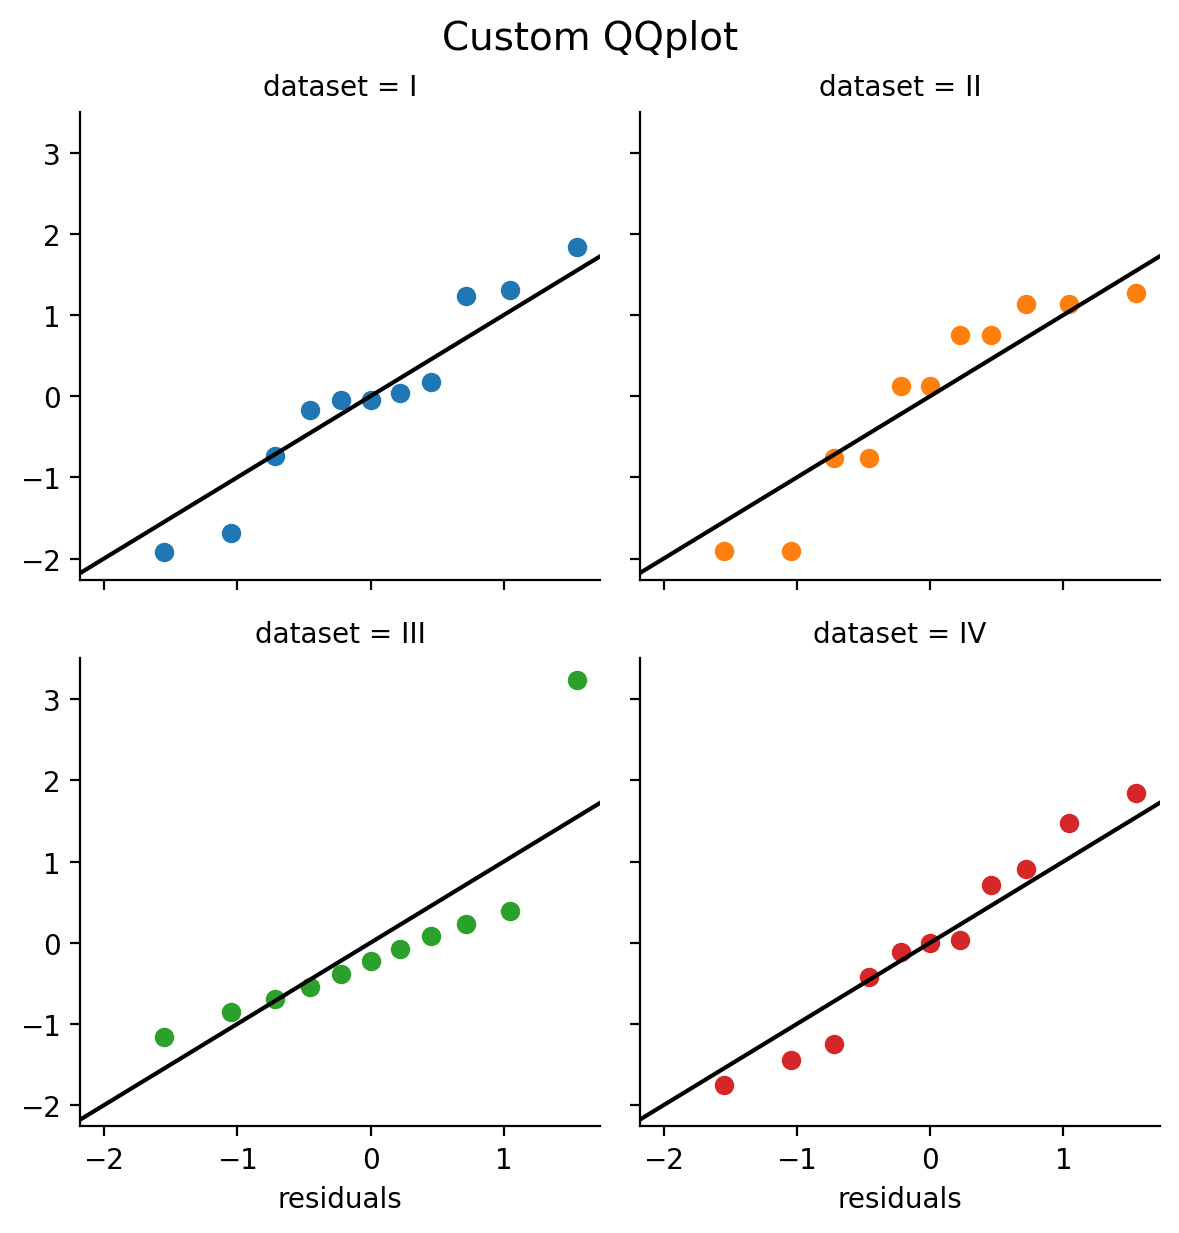

In [49]:
# Then we create a facet grid
grid = sns.FacetGrid(data=anscombe.to_pandas(), col='dataset', hue='dataset', col_wrap=2);

# And ap our custom function to each facet and pass the residuals column to x
grid.map(qqplot_custom,'residuals');

grid.figure.suptitle("Custom QQplot", y=1.02, fontsize=14);

It also might be nice to see a regular residual plot

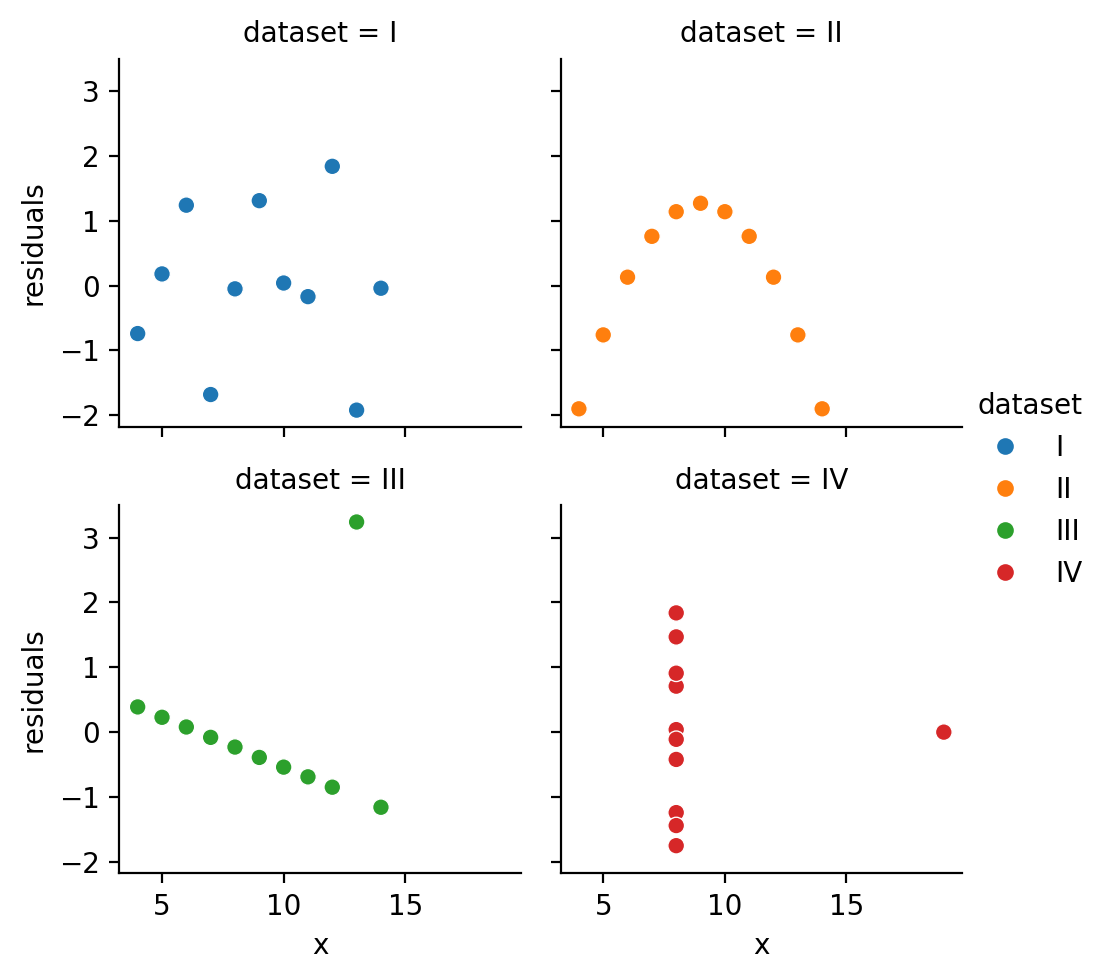

In [102]:
sns.relplot(
    data=anscombe,
    kind='scatter',
    x='x',y='residuals', 
    col='dataset', hue='dataset',
    col_wrap=2,
    height=2.5,
)

We can achieve the same thing by using a `FacetGrid` and mapping `sns.residplot` to each facet.  
But this doesn't give us a lot of control over the residuals themselves. `seaborn` will calculate the `ols` in the background but we can't access them or modify the model:

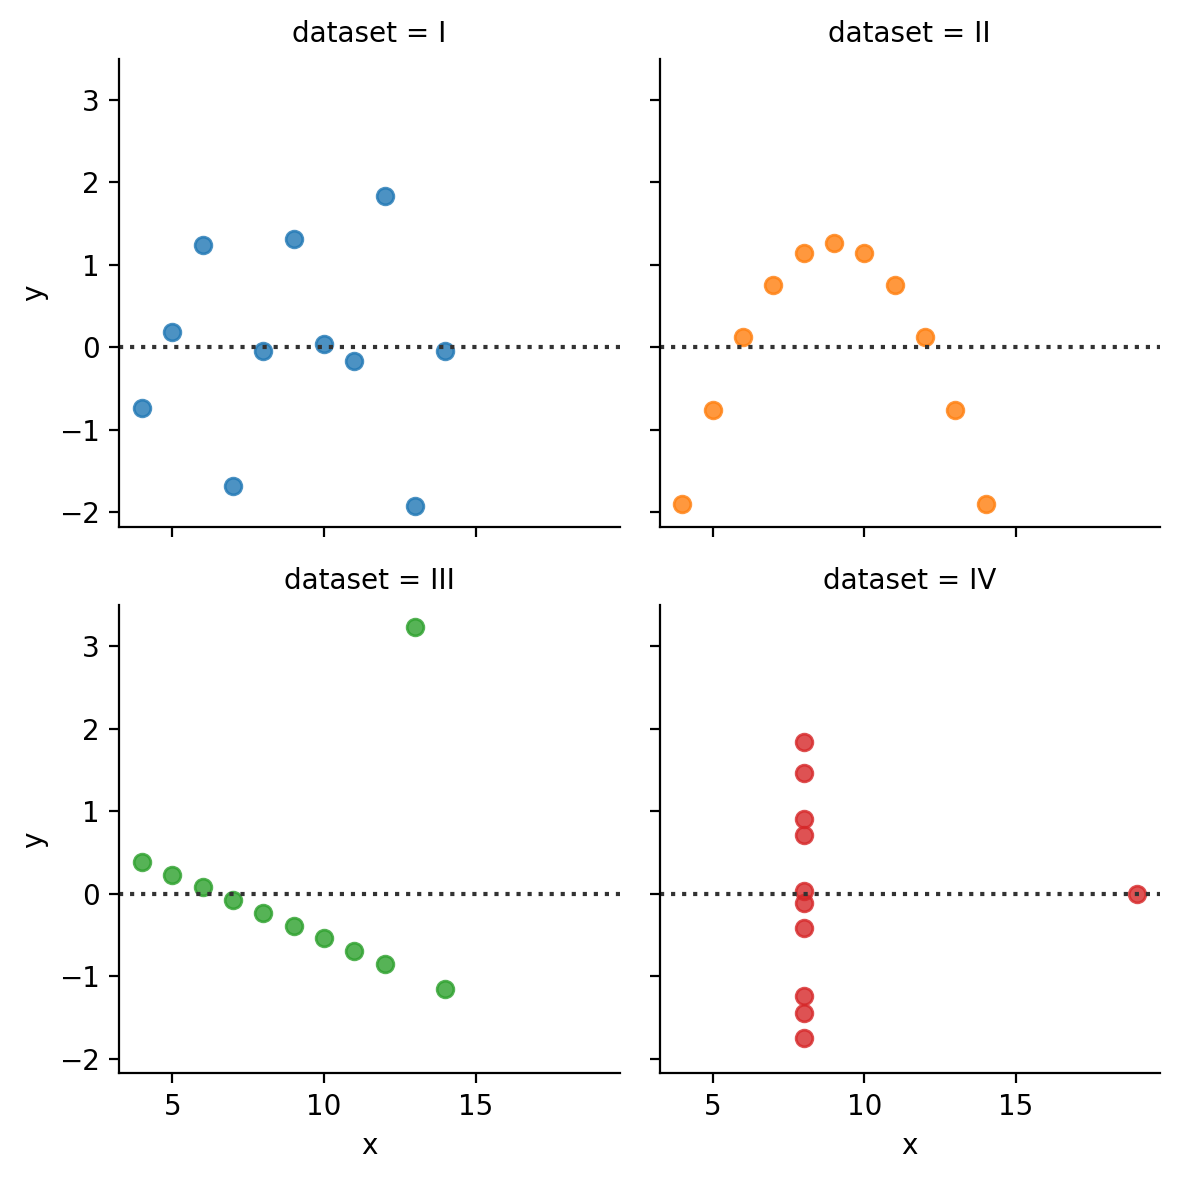

In [50]:
grid = sns.FacetGrid(data=anscombe.to_pandas(), col='dataset', hue='dataset', col_wrap=2);
grid.map(sns.residplot, 'x', 'y')

## 4. Model Comparison

Now that we've seen how to estimate a model using `ols` how do we know whether the slope we're observing between **Income** and **Balance** is meaningful? 

In class we learned that we can formulate our hypotheses as **model comparisons**, i.e. comparing a *compact* model to an *augmented* model and asking whether the **trade-off** between adding more parameters and the proportional reduction in error (PRE) is **worth it**.


<div align="center">
<img src="./figs/model_comparison.png" width="90%" alt="Figure 1">
</div>


### The Manual Way: Building Intuitions

Let's see how to implement this using `statsmodels` ourselves. We already have our *augmented* model that includes **Income** as predictor. So let's create and fit a *compact* model that doesn't:

In [51]:
# Model with only an intercept term - i.e. mean of Balance
compact_model = ols("Balance ~ 1", data=df.to_pandas())
compact_results = compact_model.fit()

# Same as our model above, just redefining it here for clarity
# 2 parameters: Intercept + Slope of Income
augmented_model = ols("Balance ~ Income", data=df.to_pandas())
augmented_results = augmented_model.fit()

Now let's calculate our PRE using the SSE of each model. Remember we can access this using the `.ssr` attribute of a model's results object:


In [52]:
error_c = compact_results.ssr
error_a = augmented_results.ssr

PRE = (error_c - error_a) / error_c

print(f"Proportional Reduction in Error: {PRE:.2f}")

Proportional Reduction in Error: 0.21


This tells us that adding **Income** as a predictor reduces our SSE in predicting **Balance** by about 21%.  
This estimate is the same as our **coefficient of variation** ($R^2$) from earlier!  
It turns out for *univariate regression only*, the PRE is identical to the coefficient of variation!

That seems good, but is it **worth it**?

To answer this question we need to know the *sampling distribution* of PRE - i.e. how *uncertain* we are about this single PRE we calculated. Had we collected another dataset, our PRE could be a bit different...

We could use what we learned about **resampling** to calculate this distribution, but we'll explore that later...  

For now,  a shortcut we can exploit is that the sampling distribution of PRE is awfully similar to the sampling distribution of the F-statistic (see above image).  
In fact we can convert between the two, and get the **analytic sampling distribution**  as follows:

<div align="center">
<img src="./figs/fstat.png" width="50%" alt="Figure 1">
</div>

Let's calculate that now:

In [53]:
pa = 2 # intercept + slope
pc = 1 # intercept only
n = df.height

F = (PRE / (pa - pc)) / ((1 - PRE) / (n - pa)) 

print(f"PRE to F: {PRE:.2f} to {F:.2f}")

PRE to F: 0.21 to 108.99


To look up the analytic sampling distribution and calculate a p-value we can use `scipy` which contains many different types of [distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions). We'll import the F distribution and look for proportion of values equal to greater than our observed F-statistic.

We can use the **cumulative distribution function** of the F-statistic as our sampling distribution - this is a distribution of *probabilities* that F will take on some value given some "degrees of freedom."


In [54]:
from scipy.stats import f

# Difference in number of model degrees of freedom = difference in number of parameters
model_df = pa - pc

# Error df = number of observations - number of model parameters in augmented model
error_df = df.height - pa

pval = 1 - f.cdf(F, model_df, error_df)

print(f"Proportion Reduction of Error: = {PRE:3f}, F = {F:3f}, p = {pval:.4f}")

Proportion Reduction of Error: = 0.214977, F = 108.991715, p = 0.0000


To visualize this sampling distribution we can use the following helper function provided by your instructors.

But with such a large F-statistic the rejection region is off the plot - it's very *worth it* to add this additional parameter!

Proportion Reduction of Error: 0.215, F = 108.992, p = 0.0000


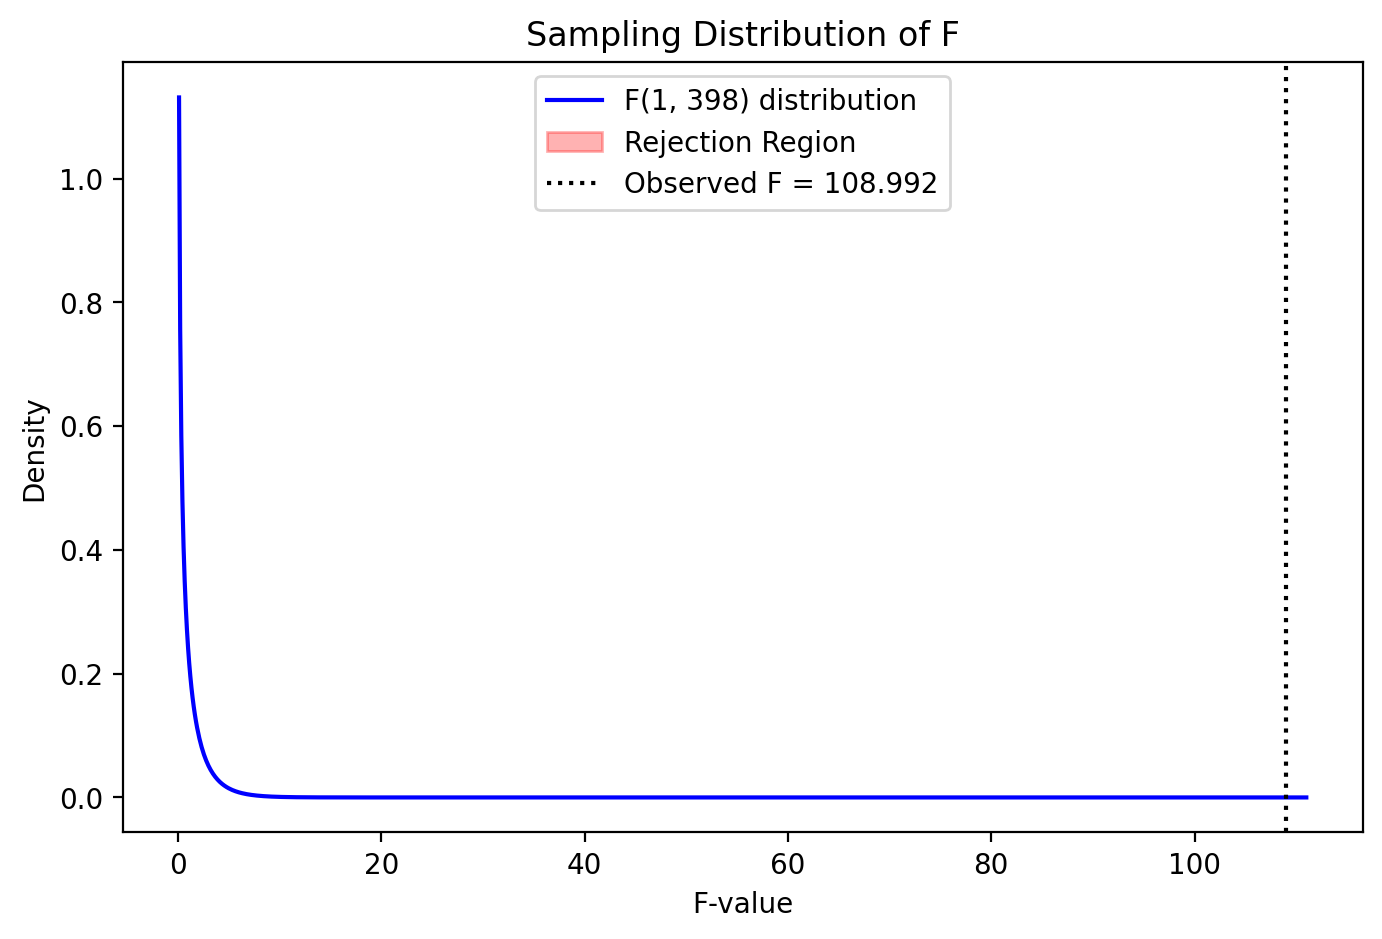

In [55]:
from helpers import plot_F_sampling_distribution
plot_F_sampling_distribution(PRE, F, pval, pa, pc, n)

#### Aside on degrees of freedom

Ok let's take a second to try to understand degrees of freedom (df) a little better. DF is the number of dimensions along which a quantity can vary. For example, let’s say we have the following data points for a variable $x: [3, 5, 7, 9, 11]$, and estimate the sample mean which is $7$. With this estimate in hand, we can recover any single value if it were missing. 

For example, let’s say we didn't know what the first value was: $x: [nan, 5, 7, 9, 11]$

Using the mean we estimated, $7$, we know that this value *must* be $3$. It's value is "fixed" and thus determined by the rest of the values and the mean we calculated. Why? Because the mean of $7$ implies that the sum of all of the values is $7 * n = 35$. And $35 - (5 + 7 + 9 + 11) = 3$.

When you think/read about "losing" or "consuming" a degree of freedom, it means that there is an observation who's  value that is no longer free to vary after estimating a parameter. This is why we often "correct" for degrees of freedom in sample statistics, like the sample variance by dividing by $n-1$:


$$\sigma^2_x = \frac{\sum_{i=1}^n (x_i - \bar{x})^2}{n-1}$$

Because the sample variance $\sigma_x^2$ is a function of the sample mean $\bar{x}$, we have 1 data-point who's value is *fixed* based upon is *this particular* sample mean. Hence the true number of *independent* observations we have is $n-1$

#### Degrees of freedom in GLM

In the GLM, degrees-of-freedom are associated with both the *independent parameters* (**model df**) and *independent errors* (**error df**).

**Model df** (or "numerator df") is generally equal to the number of parameters $p$, assuming none of the predictors in X are redundant. For our compact model, $p = 1$ because we're only estimating 1 parameter, the intercept.  
Likewise, for our augmented model $p = 2$ because we're estimating *both* an intercept *and* a slope.

**Error df** (or "denominator df"), assuming the errors are independent, is the number of observations ($n$) minus the number of model parameters estimated ($p$). For our compact model this is $400 - 1$ and for our augmented model it is $400 - 2$.

Using these values we can using the `f.cdf` function like we did above to calculate the p-value associated with our calculated F-statistic!

### The Easier Way: What you'll do in practice

Fortunately `statsmodels` has a built-in function to automate this process for us: `anova_lm()`. This function takes 1 or more results from fitted `ols` models and compares them in the same way we just did:

In [56]:
# Due to a quirk of how statsmodels was made, we need to import and use anova_lm() like this
import statsmodels.api as sm 

sm.stats.anova_lm(compact_results, augmented_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,399.0,8.433991e+07,0.0,NaN,NaN,NaN
1,398.0,6.620874e+07,1.0,1.813117e+07,108.991715,1.030886e-22


Notice we get the same F-statistic and p-value as before!

### Parameter Inference: Meet `.summary()`

Up until now we've been manually accessing the various attributed of the results from a fitted model, e.g. `results.ssr`.  
Of course, like R `statsmodels` can provide all these values plus additional information in a handy *summary*.

We can use the `.summary()` method on a results object to get all of these statistics plus more in a single line of code:

In [57]:
# Note: I find it a bit easier to read the summary table if you put it inside a print() function
print(augmented_results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     109.0
Date:                Wed, 12 Feb 2025   Prob (F-statistic):           1.03e-22
Time:                        16:47:16   Log-Likelihood:                -2970.9
No. Observations:                 400   AIC:                             5946.
Df Residuals:                     398   BIC:                             5954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    246.5148     33.199      7.425      0.0

This [website](https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/) has a comprehensive breakdown of this output.  

But let's highlight the key statistics that we've been focusing on so far and remind ourselves what they mean:

- $F\ statistic$: the `F` value we calculated using the PRE
- $DF\  Residuals$: number of observations (400) minus the number of parameters (2) we estimated
- $Prob\ (F\ statistic)$: the `pval` value we calculated using analytic sampling distribution of `F`
- $\beta_0$: the `coef` value of the `Intercept`
- $\beta_1$: the `coef` value of the `Income`



#### Parameter Inference as nested model comparison

We haven't talked about what the $t$ or $std err$ of each parameter means yet, but you might notice that for **Income**, the statistic $t$ is equal to $\sqrt{F}$, i.e. $10.44 = \sqrt{108.99}$


In [58]:
np.sqrt(results.fvalue) 

np.float64(10.439909730990184)

In [59]:
results.tvalues['Income']

np.float64(10.439909730990186)

This tells us that when we talk about performing statistical inference on a **parameter estimate**, it's proportional to performing a comparison between 2 **nested models**:

- a *compact model* with some parameters
- an *augmented model* with all the same parameters *plus* a new one we want to make an inference about, e.g. $Income$ 

In other words, testing the hypothesis that the slope of **Income** in predicting **Balance** is different that 0:

$$
H_0: \beta_1 = 0 \\
H_1: \beta_1 \neq 0 \\
$$

is equivalent to testing whether the proporational reduction in error (PRE), between two models, that differ only in that parameter, is *worth it*:

$$
\begin{align*}
H_0: \hat{Balance}_i &= \hat{\beta_0} \\
H_1: \hat{Balance}_i &= \hat{\beta_0} + \hat{\beta_1} Income_i \\
\end{align*}
$$

In a later notebook we'll talk about how to perform parameter inference using the **uncertainty** of each $\hat{\beta}$ estimate (i.e. it's standard-error), but the interpretation doesn't really change! 

## 5. Wrap-up

### Reporting Results

Putting it all together we might write up our results like this:

*We observed, a significant relationship between a person's income and the average balance on their credit cards F(1, 389) = 108.99, p < .001, r = .463.*  
*With each additional $1000 of income, a person's average balance is predicted to increase by $6.05 [4.91 7.19]*


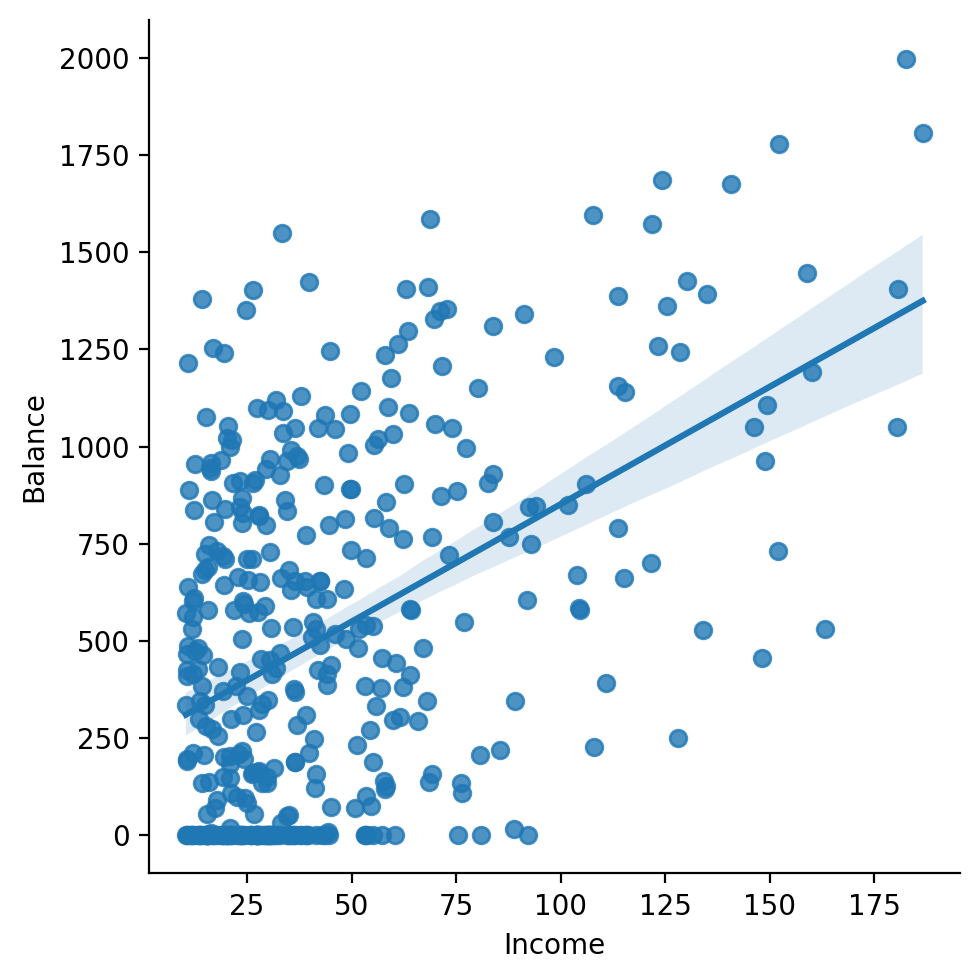

In [60]:
sns.lmplot(data=df, x='Income', y='Balance')

## Summary

In this notebook we met `statsmodels` which allowed us to much more easily estimate univariate regression models using `ols`. 
We also learned how to evaluation a model by inspecting its residuals and fitted values using `seaborn`.  
Finally we demonstrated how we can test hypotheses by comparing modes to each other.  
And how parameter inference (whether or not a parameter is statistically different from 0) is equivalent to comparing 2 models with and without the parameter.

Here's a list of basic steps you may want to keep in mind as we move forward with multiple regression and categorical predictors later this week:

1. Define a model using `ols()` and a formula
2. Estimate a model `.fit()` and save the results to a variable
3. Inspect attributes of the saved results and use `seaborn` to plot them and evaluate model assumptions
4. Formulate hypotheses as nested-model comparisons between a compact and augmented model and use `anova_lm()` to compare them
5. Inspect parameter inferences *after* model selection using `.summary()`

## Challenge

Use the same DataFrame of credit-card scores to estimate and interpret the relationship between a person's **Age** and their **Balance**.  
We've reloaded it for you below:

In [61]:
df = pl.read_csv('./data/credit.csv')
df.head()

Index,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
i64,f64,i64,i64,i64,i64,i64,str,str,str,str,i64
1,14.891,3606,283,2,34,11,"""Male""","""No""","""Yes""","""Caucasian""",333
2,106.025,6645,483,3,82,15,"""Female""","""Yes""","""Yes""","""Asian""",903
3,104.593,7075,514,4,71,11,"""Male""","""No""","""No""","""Asian""",580
4,148.924,9504,681,3,36,11,"""Female""","""No""","""No""","""Asian""",964
5,55.882,4897,357,2,68,16,"""Male""","""No""","""Yes""","""Caucasian""",331


### 1) Visually explore the data

Does anything seem strange about the values?

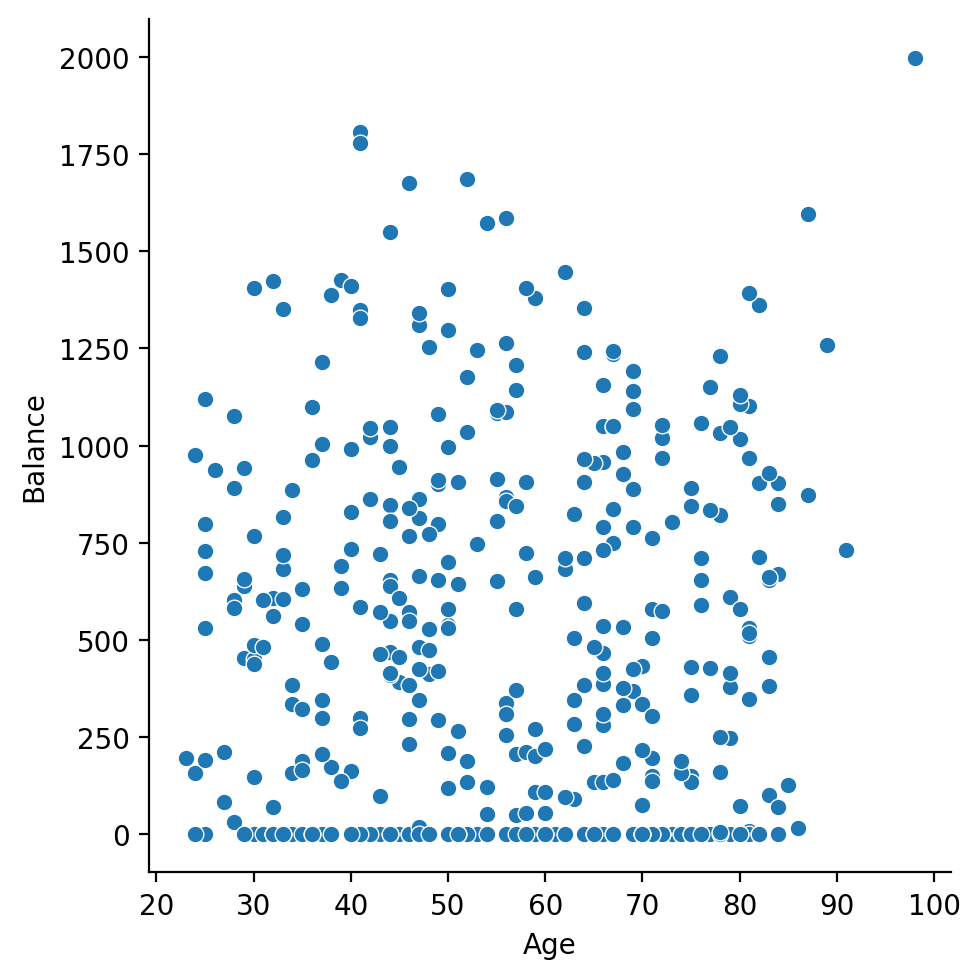

In [62]:
# Your code here
sns.relplot(
    data=df,
    x='Age',
    y='Balance'
)

### 2) Estimate a univariate regression

Use the `statsmodels` to estimate a simple univariate regression model that captures:

$$
Balance_i = \beta_0 + \beta_1 Age_i
$$

In [63]:
# Your code here
model = ols('Balance ~ Age', data=df.to_pandas())
results = model.fit()

### 3) Evaluate the model

Make some figures of the residuals and write a sentence or two describing them and what concerns you have if any

<Axes: xlabel='residuals', ylabel='Count'>

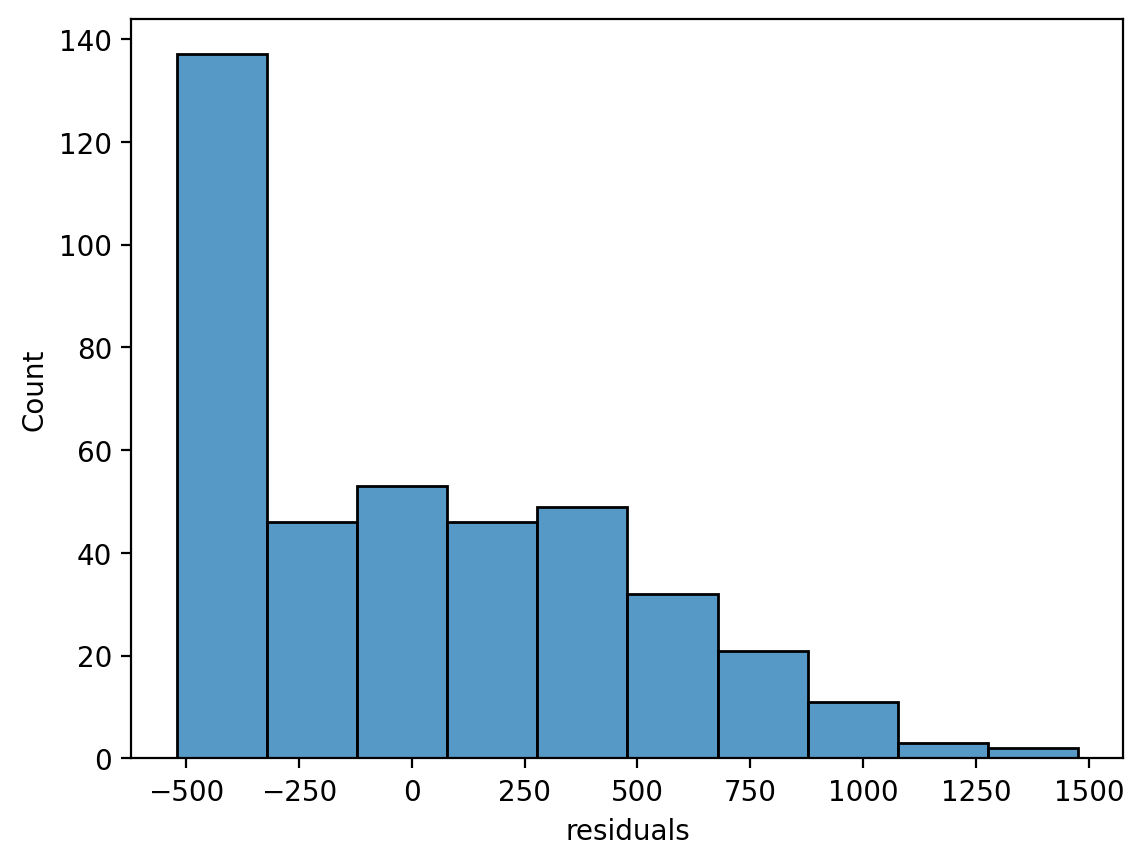

In [64]:
# Your code here
df = df.with_columns(
    residuals = results.resid.to_numpy()
)

sns.histplot(data=df, x='residuals')


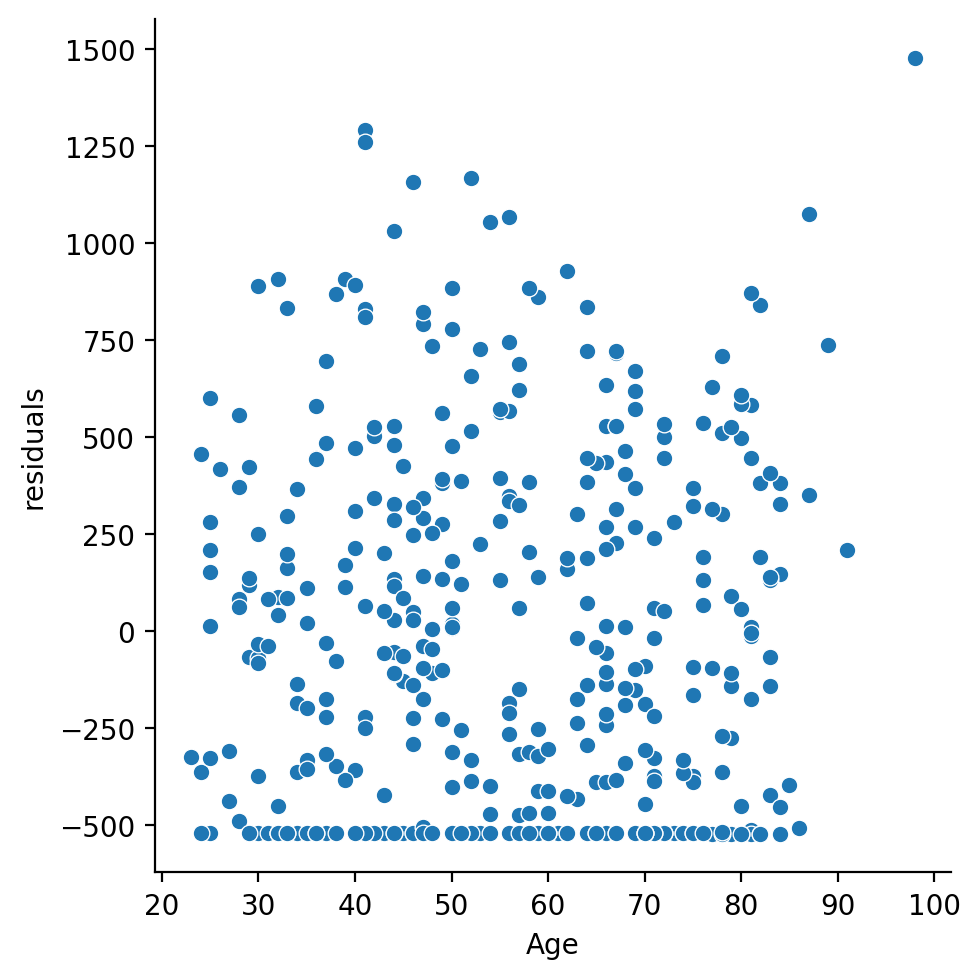

In [65]:
sns.relplot(
    data=df,
    kind='scatter',
    x='Age',
    y='residuals'
)

### 4) Test the hypothesis

Test the hypothesis that **Age** is statistically significant predictor of **Balance** using model comparison.  

In [66]:
# Your code here
from statsmodels.stats.anova import anova_lm

compact_model = ols('Balance ~ 1', data=df.to_pandas())
compact_results = compact_model.fit()

anova_lm(compact_results, results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,399.0,8.433991e+07,0.0,NaN,NaN,NaN
1,398.0,8.433963e+07,1.0,284.028251,0.00134,0.970814


### 5) Inspect the model summary

Use `.summary()` to inspect the model summary. How does the output relate to your model comparison in the previous step?

In [67]:
# Your code here
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Balance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.001340
Date:                Wed, 12 Feb 2025   Prob (F-statistic):              0.971
Time:                        16:47:39   Log-Likelihood:                -3019.4
No. Observations:                 400   AIC:                             6043.
Df Residuals:                     398   BIC:                             6051.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    517.2922     77.852      6.645      0.0